# Import

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

import json
# keys = '/gdrive/MyDrive/korobool/keys.json'
keys = '/gdrive/MyDrive/ai-labs-2022/caretech/aws/keys.json'
with open(keys) as f:
    keys = json.loads(f.read())

!pip install boto3 -q
import boto3
import botocore.config

Mounted at /gdrive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.4 MB/s eta 0:00:00


In [ ]:
# Импорт все
import os
import sys

import pandas as pd
import numpy as np
import math
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from numpy import array
from numpy import hstack

from scipy.signal import savgol_filter
from scipy.ndimage import generic_filter

from scipy.signal import freqz
from scipy.signal import butter, lfilter

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras import optimizers
from tensorflow import keras
import tensorflow as tf 

from keras.models import load_model

## module

In [ ]:
#TODO: move to package

def visual_1fig_list(X, name_list=[0], txtT='', txtX='', txtY='',  s=(10, 5), twX=0, st=0, fn=-1, vert=0, save=0):
    '''Отображение на 1 графике  >= 2 функций  
    X=[x1..xN] при мастабировании (twX=1) отображается только Legend_list[0]'''   
    if not type(twX) == list: twX = [twX]*len(X)
    if name_list==[0]: name_list *=len(X)    
    if fn==-1: fn = len(X[0])            
    c = ['r', 'b', 'g', 'k', 'm', 'brown', 'gray', 'purple', 'c', 'y'] * (len(name_list)%10+1)
    figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
    for i, x in enumerate(X):        
        if twX[i]==1: plt.twinx().plot(x[st:fn], c=c[i])
        else: plt.plot(x[st:fn], c=c[i])       
    if not vert==0: 
        for v in vert: plt.twinx().vlines(v, 0, 1)
    plt.title(txtT)
    plt.ylabel(txtY)
    plt.xlabel(txtX)
    plt.legend(name_list, loc='upper left')
    if save!=0: plt.savefig(save)
    plt.show()

def visual_1fig_df(X, name_list=[0], txtT='', txtX='', txtY='',  s=(10, 5), twX=0, st=0, fn=-1, vert=0):
    '''Отображение на 1 графике  >= 2 функций  
    X=[x1..xN] при мастабировании (twX=1) отображается только Legend_list[0]'''   
    if not type(twX) == list: twX = [twX]*len(name_list)   
    if fn==-1: fn = len(X[name_list[0]])
    c = ['r', 'b', 'g', 'k', 'm', 'brown', 'gray', 'purple', 'c', 'y'] * (len(name_list)%10+1)
    figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k')
    for i, x in enumerate(name_list):        
        if twX[i]==1: plt.twinx().plot(X[x][st:fn], c=c[i])
        else: plt.plot(X[x][st:fn], c=c[i])
    if not vert==0: 
        for v in vert: plt.twinx().vlines(v, 0, 1)
    plt.title(txtT)
    plt.ylabel(txtY)
    plt.xlabel(txtX)
    plt.legend(name_list, loc='upper left')
    plt.show()

def st_fn_div_d(Ne, d, L1):  
    '''Разбивает х(Ne=len(x) на d частей(длина одного графка=L1)
    возвращает индексы Старт, Финиш - каждой части'''  
    nn = (Ne-1)//(d*L1)
    st = [i*L1*d for i in range(nn+1)]
    fn = [st[i+1] for i in range(nn)] + [Ne]
    return st, fn
    
def vert(x, st=0, fn=-1):
    return [i for i,x in enumerate(x[st:fn]) if not x==0]

# ____________ANALIZ______________
def analiz_predict(x1, d_max):
    L = len(x1); 
    t1 = dl_segm / fs
    i1 = get_sharp_start(x1, dt = 0, N=5)
    i2 = get_sharp_finish(x1, dt = 0, N=5, kR=5)   
    v = sum(x1[i1:i2])*t1
    m = max(x1) #*d_max      
    im = max([0 if x1[i]<m else i for i in range(L)])   
    tm = (im) * t1    # f = 58 dl_segm=33pts
    T = (i2-i1) * t1      
    TQmax = (im-i1)*t1
    return i1, i2, im, m, v, T, TQmax

def MXE(x1, x2):
    L = len(x1)   
    MAE = sum([abs(x1[i]-x2[i]) for i in range(L)])/L
    MSE = sum([(x1[i]-x2[i])**2 for i in range(L)])/L
    MSE_1 = MSE**0.5    
    return MAE, MSE, MSE_1    

# ____________STUPEN______________
def add_Np_Nh(x, Nph, Nmax=100):
    '''ADD in segment[Np, Nh] '''    
    x['Np'] = Nph[0]/Nmax;   x['Nh'] = Nph[1]/Nmax

def his(h, N):
    mx=max(h); mn=min(h)
    L1 =(mx+1-mn)/N

    h1 = [[mn+L1*i, mn+L1+L1*i] for i in range(N)]
    t=[0]*N
    for i in range(N):
        for x in h:
            if h1[i][0]<=x<h1[i][1]:
                t[i]+=1
    # print(L1, mx, mn+N*L1 -mx)
    return t, [L1, mn, mx]

def center(x, m=0.9):      
    s=sum(x)/2; c=0
    for i in range(len(x)):        
        if sum(x[:i]) > s: break
        c=i 
    s = sum(x)*(1-m)
    L=len(x)
    s1, s2 = 0, L-1
    for i in range(len(x)):        
        if sum(x[:i]) > s: break   
        s1=i     
    for i in range(len(x)):  
        s2=L-i      
        if sum(x[L-i:]) > s: break        
    return c, s1, s2


def sglad_N(x, n=1):
    def sgl(x):
        res = [0]*len(x)
        res[0] = (x[1]+x[0])/2 
        res[-1] = (x[-1]+x[-2])/2
        for i in range(1,len(x)-1):
            res[i] = (x[i]+x[i-1]+x[i+1])/3
        return res
    for i in range(n):
        x = sgl(x)
    return x

def stup_max(x):
    res = []
    L = len(x)
    s=0; f=0
    fb=0
    for i in range(1,L):
        if x[i]>x[i-1]: 
            ti=1; s=i
            if not fb==ti: fb=ti

        if x[i]<x[i-1]: 
            ti=0; f=i 
            if not fb==ti: 
                fb=ti
                res += [int((s+f)/2)]                
    return res

def N_dh(s,h1,h2):
    i1,i2,n1,n2 = 0, 0, h1-s[0], h2-s[0]
    for i,s1 in enumerate(s): 
        if abs(h1-s1)<n1: i1=i; n1=abs(h1-s1)
        if abs(h2-s1)<n2: i2=i; n2=abs(h2-s1)         
    return i2-i1

def n_level_cor(x, h1, h2, N=1000, p=0.95, Ns=8):
    '''=> Np, Nh, (dsM, Ns)'''    
    h, param = his(x, N)
    L1, x1 = param[0], param[1]
    c, s1, s2 = center(h, p)    
    h1, h2 = int((h1-x1)//L1)-s1, int((h2-x1)//L1)-s1           
    sh = sglad_N(h[s1:s2], Ns)
    sM = stup_max(sh)
    dsM = [sM[i]-sM[i-1] for i in range(1, len(sM))]
    dt = min(max(dsM)-min(dsM), max(dsM[:-1])-min(dsM[:-1])) 
    Np = len(sM)    
    Nh = N_dh(sM,h1,h2)   
    if dt>=6:        
        for i in range(5,20):
            sh = sglad_N(h[s1:s2], i)
            sM = stup_max(sh)
            dsMi = [sM[i]-sM[i-1] for i in range(1, len(sM))]
            dti = min(max(dsMi)-min(dsMi), max(dsMi[:-1])-min(dsMi[:-1]))                 
            if dti<=6:
                Np = len(sM)    
                Nh = N_dh(sM,h1,h2)  
                dsM = dsMi
                Ns = i 
                dt =dti
                break    
    return  Np, Nh  #,  dsM, Ns
# __________________________________


def load_file_c_b(keys, csvs, bins, verbose=False):
    '''загрузка файлов csv bin'''
    session = boto3.Session(aws_access_key_id=keys['aws_access_key_id'], 
                            aws_secret_access_key=keys['aws_secret_access_key'])
    client = session.client(
        "s3",
        config=botocore.config.Config(region_name="eu-north-1", signature_version="s3v4"),
        )
    aws_objects_keys = bins + csvs
    for key in aws_objects_keys:
        client.download_file("caretech-uploads-old", key, key.split("/")[-1])
        if verbose: print(key)

def read_bin(bin_file_name, Time_period=58):
    '''Возвращает DF 
    ''' 
    with open(bin_file_name) as f:
        data = np.fromfile(f, dtype='<u2')
    df = pd.DataFrame(data, columns=['distance(mm)'])
    df['measure time(ms)'] = df.index * (1000/Time_period)
    return df


def interpolate_data_join1(flowmetr, sharp, shift=0):
    '''Расчет sharp[интерпол(flowmetr)]
    Добавляет: sharp['ev'] и sharp['ef']
    со смещением - вправо на shift точек'''
    train_item = []
    x_f = flowmetr['time_ms']-flowmetr['time_ms'][0]
    y_f = flowmetr['flow_meter']    
    x_s = sharp['measure time(ms)']
    kN = len(x_f) - 1    
    k = 0
    for i, x in enumerate(x_s):
        if i == 0 : 
            train_item.append(y_f[0])            
        elif k >= kN:
            train_item.append(y_f[kN])     
        elif x < x_f[k+1]:
            train_item.append(y_f[k] + (y_f[k+1]-y_f[k])/(x_f[k+1]-x_f[k]) * (x-x_f[k]) )            
        else:    
            k += 1
            if k == kN: 
                train_item.append(y_f[kN] )
            else:
                train_item.append(y_f[k] + (y_f[k+1]-y_f[k])/(x_f[k+1]-x_f[k]) * (x-x_f[k]) )

    y_shift = [train_item[0] for i in range(shift)] + train_item[:-shift]    
    sharp['ev'] = np.array(y_shift)   # volume_extrapolated
    dy_shift = np.insert(y_shift, 0, y_shift[0])
    sharp['ef'] = np.diff(dy_shift)   # flow_extrapolated


def get_sharp_finish(signal, dt = 0, N=10, kR=3):
    '''Возвращает индекс ФИНИША по sharp['ef']'''
    s1 = signal[::-1]
    L = len(s1)
    # N = 10   
    R0 = (max(s1[:N]) - min(s1[:N]))
    x0 = min(s1[:N]) + R0/2
    for i,x in enumerate(s1):
        dx = (x - x0) #abs(x - x0)
        if dx > R0 * kR:          
            break
    # print(i)
    return L - i + dt
     

def get_sharp_start(signal, dt = 0, N=10, kR=3):
    '''Возвращает индекс СТАРТА по sharp['ev']'''
    # N = 10   
    R0 = (max(signal[:N]) - min(signal[:N]))
    x0 = min(signal[:N]) + R0/2
    for i,x in enumerate(signal):
        dx = abs(x - x0)
        if dx > R0 * kR:          
            break
    # print(i)
    return i - dt

def get_start_x(x, N=50, kR=2, N_del=50, dt = 0):
    '''Возвращает индекс СТАРТА, FINISH по sharp['x']'''        
    x1 = x[::-1]; L = len(x); dt1=0
    R0 = max(x[N_del:N_del+N]) - min(x[N_del:N_del+N])
    R1 = max(x1[N_del:N_del+N]) - min(x1[N_del:N_del+N])
    R0 = max(R0,R1)

    x0 = min(x[N_del:N_del+N]) + R0/2
    for i,xi in enumerate(x[N_del:]):
        dx = abs(xi - x0)
        if dx > R0 * kR:          
            break
    if i>dt: dt1 = dt
    start = i+N_del - dt1      
    
    x0 = min(x1[N_del:N_del+N]) + R0/2
    for i,xi in enumerate(x1[N_del:]):
        dx = abs(xi - x0)
        if dx > R0 * kR:          
            break
    if i>dt: dt1 = dt
    finish = L - i + dt1
    return start, finish


def add_SF(x, start, Nel=1400):     
    '''Возвращает np.array длина = 2*Nel
    [0..Nel]=x[0] + [Start...Finish] + [f..2*Nel]=x[f]'''
    t = list(x[start:])          
    res = [t[0]]*(Nel) + t + [t[-1]]*(Nel-len(t))    
    return np.array(res)

def add_data_n2(x, nx, start, Nelem, no_csv=0): 
    '''Добавляет в nx(х) - дл=2*Nel: 
     nx['xx'] ['ev'] ['ef']'''      
    nx['xx'] = add_SF(np.array(x['distance(mm)']), start, Nelem)
    if no_csv==0:
        nx['ev'] = add_SF(np.array(x['ev']), start, Nelem)  
        nx['ef'] = add_SF(np.array(x['ef']), start, Nelem) 


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    '''Филтр средних частот - возвращает отфильтр data'''
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    '''Филтр нижних частот - возвращает отфильтр data'''
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def feature_data_join(x, fs=50, size_d=166): #size_d = segment
    '''Добавляет в x(сигнал = x['xx'] ['d'] ['ds'] ['f_03'] ['f_1'] ['f_nf_1'
     x['fil'] ['fl'] ['fh'] ['fnl'] ''' 
    y = x['xx']   

    x['f_03'] = butter_lowpass_filter(y, 0.3, fs, order=5)   # infra_low_freq
    x['f_1'] = butter_lowpass_filter(y, 1, fs, order=5)      # low_freq     
    x['f_1_28'] = butter_bandpass_filter(y, 1, 28, fs, order=5) # high_freq      
    x['f_1_5'] = butter_bandpass_filter(y, 1, 5, fs, order=5)
    x['f_5_15'] = butter_bandpass_filter(y, 5, 15, fs, order=5)
    x['f_15_20'] = butter_bandpass_filter(y, 15, 20, fs, order=5)
    x['f_20_28'] = butter_bandpass_filter(y, 20, 28, fs, order=5)
    
    x['f_nf_1'] = y - x['f_1']                                  # no_low_freq
    x['d'] = generic_filter(x['f_nf_1'], np.std, size=size_d) # dispersion
    x['ds'] = savgol_filter(x['d'], 151, 3)                 # disp_savgol

    # x['ds_f_03'] = savgol_filter(generic_filter(x['f_03'], np.std, size=size_d), 151, 3)     # disp_savgol
    x['d_f_03'] = generic_filter(x['f_03'], np.std, size=size_d)
    x['d_f_1'] = generic_filter(x['f_1'], np.std, size=size_d)
    x['d_f_1_28'] = generic_filter(x['f_1_28'], np.std, size=size_d)
    x['d_f_1_5'] = generic_filter(x['f_1_5'], np.std, size=size_d)
    x['d_f_5_15'] = generic_filter(x['f_5_15'], np.std, size=size_d)
    x['d_f_15_20'] = generic_filter(x['f_15_20'], np.std, size=size_d)
    x['d_f_20_28'] = generic_filter(x['f_20_28'], np.std, size=size_d)

def add_data_f( nx, Nelem):    
    '''Коррекция начали/конца сигнала после частотного фильтра
    ['fl'] ['fh'] ['fnl'] ['ds']'''
    nx['ds'] = add_SF(np.array(nx['ds']), Nelem, Nelem)
    nx['f_03'] = add_SF(np.array(nx['f_03']), Nelem, Nelem) 
    nx['f_1'] = add_SF(np.array(nx['f_1']), Nelem, Nelem) 
    nx['f_nf_1'] = add_SF(np.array(nx['f_nf_1']), Nelem, Nelem)
    nx['f_1_28'] = add_SF(np.array(nx['f_1_28']), Nelem, Nelem)   
    nx['f_1_5'] = add_SF(np.array(nx['f_1_5']), Nelem, Nelem)  
    nx['f_5_15'] = add_SF(np.array(nx['f_5_15']), Nelem, Nelem)  
    nx['f_15_20'] = add_SF(np.array(nx['f_15_20']), Nelem, Nelem)  
    nx['f_20_28'] = add_SF(np.array(nx['f_20_28']), Nelem, Nelem)  

def d_max_calc(x, list_k): 
    '''Возврвщает d_max = dict(k:v) k-параметр v-max
    list_k=['xx','ev','ef','fil','fl','fh','fnl','d','ds']
    x=df.n2'''
    list_v = [0]*len(list_k)
    d = dict(zip(list_k, list_v))
    d2 = {k: [max(i[k]) for i in x] for k in d}
    d_max = {k:max(v) for k,v in d2.items()}
    return d_max


def norm(x, d_max):    
    '''Нормализация - добавляет x['n_'+k] = x[k] / v
    где d_max = dict(k:v) k-параметр v-max'''
    for k,v in d_max.items():
        x['n_'+k] = x[k] / v    


def add_segm(x, Ns, segm, ds):  
    '''Возвращает np: дл=2*Ns,
    1сегм=среднее значение'''  
    res = add_SF([np.mean(x[(i*ds-segm):i*ds]) for i in range(Ns, 2*Ns)], 0, Ns)
    return res

def add_disp(x, Ns, segm, ds):
    '''1сегм= 1 элемент '''
    res = [x[i*ds] for i in range(Ns*2)]
    return np.array(res)

def add_data_segment(x, nx, Ns, segm, ds, d_max):  
    '''Сегментация nx[k] = add_segm(x['n_'+k])
    segm=дл.сегм, Ns=кол.сегм, ds=шаг, d_max{k:v}=словарь из норм.
    '''    
    for k in d_max:          
        nx[k] = add_segm(np.array(x['n_'+k]), Ns, segm, ds)
    nx['d'] = add_disp(np.array(x['n_d']), Ns, segm, ds)


def extrem(x):
    '''Возвращает список [0 0 Mx 0 0 Mn 0 0...]'''
    delta = lambda x,y : 0 if (x==y) else -1 if x>y else 1
    L = len(x)
    res = [0]*L
    res1 = [0]*L
    d0 = 1
    for i in range(L-1):
        di = delta(x[i], x[i+1])        
        if di*d0 < 0: 
            d0 = di
            # Совпадают - при визуал 1сегм - res[i] При визуал Нпрам - res[i-1]
            res[i] = x[i]                 #res[i-1] = x[i] 
            if di < 0 : res1[i] = x[i]    #res1[i-1] = x[i] 
    return res, res1

def add_extr(x):  
    '''Добавляет x['mx']=макс(x['ef']) и x['mn_mx']=макс&min(x['ef']) '''      
    x['mx'] = np.array(extrem(x['ef'])[1])
    x['mn_mx'] = np.array(extrem(x['ef'])[0])

def add_L(x, L1, L2, mx):
    x['L1'] = L1/mx
    x['L2'] = L2/mx

def truncate(x):  # x.segment.ef  - вместо х
    ''' np ==> list - для формирования У=сум(у) '''
    # return list(x.segment.ef)[:]
    return list(x)[:]


def vectorize(x, N, start, param_names): 
    '''Формирует Х(Nфайлов, 2хNsegm, N_param) - list[]
    param_names = ['xx', 'fl', 'fnl', 'fh', 'ds', 'd'] '''  
    return [[(x[k][i]) for k in param_names] for i in range(start, start+N)]
 

def split_step(x, step=120):  # step = Nsegm 
    '''Формирует Х - для LSTM model
    x[0..N] ==> x_step[ [0..st] .. [N-st..N] ] '''
    n_x = len(x)  
    x_step = ([x[i-step:i] for i in range(step, n_x)])     
    return (x_step)


#-------- BINS ==> X -------

def bin_x0(bins, d_max, param_names, segment, Nsegm, fs=58, size_d=166, Nhp_max=100):  
    '''return x0'''    
    d_max = {k:v for k,v in d_max.items() if (not k=='ev') and (not k=='ef')} # delet ev,ex 
        
    df0 = pd.DataFrame(bins)   
    df0['sharp'] = df0[0].apply(lambda x: read_bin(x, fs))     
    dt = 40 # !!!!!!! Start + dt - отступ от Старта точек
    df0['start_sharp'] = df0['sharp'].apply(lambda x: get_start_x(x['distance(mm)'], kR=2, N=50, N_del=50, dt=dt)[0])    
    df0['finish_sharp'] = df0['sharp'].apply(lambda x: get_start_x(x['distance(mm)'], kR=2, N=50, N_del=50, dt=dt)[1]) 

    df0['time_len'] = df0['finish_sharp'] - df0['start_sharp']
    df0['period'] = df0.sharp.apply(lambda x: len(x['distance(mm)'])) - df0['start_sharp']
  
    df0['L1'] = df0.apply(lambda x: sum(x['sharp']['distance(mm)'][x['start_sharp']:x['start_sharp']+dt]) /dt, axis=1)
    df0['L2'] = df0.apply(lambda x: sum(x['sharp']['distance(mm)'][x['finish_sharp']-dt:x['finish_sharp']])/dt, axis=1)

    N = min(df0.period)
    Nmax = max(df0.period)
    dl_segm = Nmax//Nsegm + 1
    Nelem = Nsegm*dl_segm

    df0['n2'] = df0.sharp.apply(lambda x: pd.DataFrame({'ind': [i for i in range(Nelem*2)]}))
    df0['segment'] = df0.sharp.apply(lambda x: pd.DataFrame({'ind': [i for i in range(Nsegm*2)]}))
# no_csv=1
    _ = df0.apply(lambda x: add_data_n2(x.sharp, x.n2, x.start_sharp , Nelem, no_csv=1), axis=1)    #Созд n2 - добавлен SF    
    _ = df0.apply(lambda x: feature_data_join(x.n2, fs, size_d), axis=1)    #Расчет параметров - фильтры частот  
    _ = df0.apply(lambda x: add_data_f(x.n2, Nelem), axis=1)                #Отсекание нач/кон - чстот фильтров      
    _ = df0.apply(lambda x: norm(x.n2, d_max), axis=1)                      #norm(x):    d_max = [xx ev ef fil fl fh fnl d ds]
    _ = df0.apply(lambda x: add_data_segment(x.n2, x.segment, Nsegm, segment, dl_segm , d_max), axis=1)      
    _ = df0.apply(lambda x: add_L(x['segment'], x['L1'], x['L2'], d_max['xx']), axis=1) # add L1, L2
 #   _ = df0.apply(lambda x: add_extr(x.segment), axis=1)                   # def add_extr(x):    
    
    # Nhp_max=100
    N_level = {'N_hist':1000, 'p':0.95, 'N_s':8}      
    if 'Np' in param_names or 'Nh' in param_names :
        df0['Nph'] = df0.apply(lambda x: n_level_cor(x['sharp']['distance(mm)'], x['L1'], x['L2'], N=1000, p=0.95, Ns=8), axis=1)
        _ = df0.apply(lambda x: add_Np_Nh(x['segment'], x['Nph'], Nhp_max), axis=1) # add Np, Nh

    XX = df0.apply(lambda item: vectorize(item.segment, 2*Nsegm, 0, param_names), axis=1)
    X = np.array([i for i in XX])    # n_parametr = len(X[0][0])

    step = Nsegm
    x0 = []
    for x in X:   x0 +=  split_step(x, step)           
    x0 = np.array(x0)    # x0.shape
    return x0


# ------- CSV + BIN ==> X,Y-----------

def csv_y0_bin_x0(csvs, bins, d_max, param_names, segment, Nsegm, fs=58, size_d=166, Nhp_max=100):  
    '''return y0, x0'''
    # segment = 166     # Nsegm =97
    shift=200                           # !!!!!!! смещение sharp - вправо на shift точек 
    dt_start, dt_finish = 200, 0        # !!!!!!! Start + dt - отступ от Старта точек
    
    data0 = dict(zip(csvs, bins))
    df0 = pd.DataFrame(data0.items())
    df0['flowmetr'] = df0[0].apply(lambda x: pd.read_csv(x))    
    df0['sharp'] = df0[1].apply(lambda x: read_bin(x, fs))     
    
    _ = df0.apply(lambda x: interpolate_data_join1(x.flowmetr, x.sharp, shift), axis=1)      # (flowmetr=>sharp) + смещение sharp - вправо на shift точек 
    df0['start_sharp'] = df0['sharp'].apply(lambda x: get_sharp_start(x['ev'], dt_start))    # def get_sharp_start(signal, dt = 0):
    df0['finish_sharp'] = df0['sharp'].apply(lambda x: get_sharp_finish(x['ef'], dt_finish)) # def get_sharp_finish(signal, dt = 0):  
    df0['time_len'] = df0['finish_sharp'] - df0['start_sharp'] - dt_finish - dt_start
    df0['period'] = df0.sharp.apply(lambda x: len(x['ev'])) - df0['start_sharp']
  
    df0['L1'] = df0.apply(lambda x: sum(x['sharp']['distance(mm)'][x['start_sharp']:x['start_sharp']+100]) /100, axis=1)
    df0['L2'] = df0.apply(lambda x: sum(x['sharp']['distance(mm)'][x['finish_sharp']-100:x['finish_sharp']])/100, axis=1)

    N = min(df0.period)
    Nmax = max(df0.period)
    dl_segm = Nmax//Nsegm + 1
    Nelem = Nsegm*dl_segm

    df0['n2'] = df0.sharp.apply(lambda x: pd.DataFrame({'ind': [i for i in range(Nelem*2)]}))
    df0['segment'] = df0.sharp.apply(lambda x: pd.DataFrame({'ind': [i for i in range(Nsegm*2)]}))
    _ = df0.apply(lambda x: add_data_n2(x.sharp, x.n2, x.start_sharp , Nelem), axis=1)      #Созд n2 - добавлен SF
    _ = df0.apply(lambda x: feature_data_join(x.n2, fs, size_d), axis=1)                    #Расчет параметров - фильтры частот  
    _ = df0.apply(lambda x: add_data_f(x.n2, Nelem), axis=1)                                #Отсекание нач/кон - чстот фильтров   
    _ = df0.apply(lambda x: norm(x.n2, d_max), axis=1)                                      #norm(x):    
    _ = df0.apply(lambda x: add_data_segment(x.n2, x.segment, Nsegm, segment, dl_segm , d_max), axis=1)      
    _ = df0.apply(lambda x: add_extr(x.segment), axis=1)                                    # def add_extr(x):   
    _ = df0.apply(lambda x: add_L(x['segment'], x['L1'], x['L2'], d_max['xx']), axis=1)     # add L1, L2

    # Nhp_max=100
    N_level = {'N_hist':1000, 'p':0.95, 'N_s':8}      
    if 'Np' in param_names or 'Nh' in param_names :
        df0['Nph'] = df0.apply(lambda x: n_level_cor(x['sharp']['distance(mm)'], x['L1'], x['L2'], N=1000, p=0.95, Ns=8), axis=1)
        _ = df0.apply(lambda x: add_Np_Nh(x['segment'], x['Nph'], Nhp_max), axis=1) # add Np, Nh
    
    y_n = len(df0) 
    y = np.hstack(df0.apply(lambda x: truncate(x.segment.ef), axis=1).to_numpy())
    y = y.reshape((y_n, -1))
   
    XX = df0.apply(lambda item: vectorize(item.segment, 2*Nsegm, 0, param_names), axis=1)
    X = np.array([i for i in XX])
    # n_parametr = len(X[0][0])
    step = Nsegm
    y0, x0 = [], []
    for x in X:   x0 +=  split_step(x, step )        
    for yi in y:  y0 += list(yi[step:])    
    y0 = np.array(y0)
    x0 = np.array(x0)
    # x0.shape
    return y0, x0


#-------- CSV + BIN ==> PARAMETR ---------

def csv_y0_bin_x0_df(csvs, bins, list_k, param_names, segment = 166, dl_segm = 33, fs=58, size_d=166, Nhp_max=100, mix = True):  
    '''return y0, x0'''    
    # list_k = ['xx','ev', 'ef', 'd', 'ds', 
    #       'fil', 'fl', 'fh', 'fnl', 'f_1_5', 'f_5_15', 'f_15_20', 'f_20_28']
  
    shift=200                           # !!!!!!! смещение sharp - вправо на shift точек 
    dt_start, dt_finish = 200, 0        # !!!!!!! Start + dt - отступ от Старта точек   
    
    data0 = dict(zip(csvs, bins))
    df0 = pd.DataFrame(data0.items())
    df0['flowmetr'] = df0[0].apply(lambda x: pd.read_csv(x))    
    df0['sharp'] = df0[1].apply(lambda x: read_bin(x, fs))     
    
    _ = df0.apply(lambda x: interpolate_data_join1(x.flowmetr, x.sharp, shift), axis=1)  # (flowmetr=>sharp) + смещение sharp - вправо на shift точек 
    # Перемешивание
    if mix:
        df0 = df0.sample(frac=1).reset_index(drop=True)
    df0['start_sharp'] = df0['sharp'].apply(lambda x: get_sharp_start(x['ev'], dt_start))    # def get_sharp_start(signal, dt = 0):
    df0['finish_sharp'] = df0['sharp'].apply(lambda x: get_sharp_finish(x['ef'], dt_finish)) # def get_sharp_finish(signal, dt = 0):  
    df0['time_len'] = df0['finish_sharp'] - df0['start_sharp'] - dt_finish - dt_start
    df0['period'] = df0.sharp.apply(lambda x: len(x['ev'])) - df0['start_sharp']

    df0['L1'] = df0.apply(lambda x: sum(x['sharp']['distance(mm)'][x['start_sharp']:x['start_sharp']+100]) /100, axis=1)
    df0['L2'] = df0.apply(lambda x: sum(x['sharp']['distance(mm)'][x['finish_sharp']-100:x['finish_sharp']])/100, axis=1)

    N = min(df0.period)
    Nmax = max(df0.period)
    # dl_segm = Nmax//Nsegm + 1
    # Nelem = Nsegm*dl_segm
    Nelem = (Nmax//dl_segm + 1)*dl_segm
    Nsegm = Nelem//dl_segm

    df0['n2'] = df0.sharp.apply(lambda x: pd.DataFrame({'ind': [i for i in range(Nelem*2)]}))
    df0['segment'] = df0.sharp.apply(lambda x: pd.DataFrame({'ind': [i for i in range(Nsegm*2)]}))

    _ = df0.apply(lambda x: add_data_n2(x.sharp, x.n2, x.start_sharp , Nelem), axis=1)    #Созд n2 - добавлен SF    
    _ = df0.apply(lambda x: feature_data_join(x.n2, fs, size_d), axis=1)    #Расчет параметров - фильтры частот f_x
    _ = df0.apply(lambda x: add_data_f(x.n2, Nelem), axis=1)                #Отсекание нач/кон - чстот фильтров   
    
    d_max =  d_max_calc(df0.n2, list_k)
    _ = df0.apply(lambda x: norm(x.n2, d_max), axis=1)                      #norm(x):    
    _ = df0.apply(lambda x: add_data_segment(x.n2, x.segment, Nsegm, segment, dl_segm , d_max), axis=1)      
    _ = df0.apply(lambda x: add_L(x['segment'], x['L1'], x['L2'], d_max['xx']), axis=1) # add L1, L2
    _ = df0.apply(lambda x: add_extr(x.segment), axis=1)                    # def add_extr(x): 

    # Nhp_max=100
    N_level = {'N_hist':1000, 'p':0.95, 'N_s':8}      
    if 'Np' in param_names or 'Nh' in param_names :
        df0['Nph'] = df0.apply(lambda x: n_level_cor(x['sharp']['distance(mm)'], x['L1'], x['L2'], N=1000, p=0.95, Ns=8), axis=1)
        _ = df0.apply(lambda x: add_Np_Nh(x['segment'], x['Nph'], Nhp_max), axis=1) # add Np, Nh
    
    y_n = len(df0) 
    y = np.hstack(df0.apply(lambda x: truncate(x.segment.ef), axis=1).to_numpy())
    y = y.reshape((y_n, -1))   
    
    XX = df0.apply(lambda item: vectorize(item.segment, 2*Nsegm, 0, param_names), axis=1)
    X = np.array([i for i in XX])
    # n_parametr = len(X[0][0])

    step = Nsegm
    y0, x0 = [], []
    for x in X:   x0 +=  split_step(x, step )        
    for yi in y:  y0 += list(yi[step:])    
    y0 = np.array(y0)
    x0 = np.array(x0)
    # x0.shape   

    d_param = {'d_max':d_max, 'list_k':list_k,
                'param_names':param_names,  'n_parametr':len(param_names),
                'Nelem':Nelem,  'Nsegm':Nsegm, 'dl_segm':dl_segm, 'segment':segment,                
                'fs':fs, 'N_level':N_level, 'shift':shift , 'dt_start':dt_start, 'dt_finish':dt_finish, 'Nhp_max':Nhp_max}

    return y0, x0, df0, d_param


# Define and download testset (3:00 min)

https://docs.google.com/spreadsheets/d/148Hyc3RrBGAM3Et8OdDcGiC2W_KWU7-MHYfNMr_O_XE/edit?usp=sharing

In [ ]:
test_data_files = '''
1668176974_10521CBCC9F8_flowgen_1.csv	1668176972_10521CBCC9F8_sharp_58.bin
1668177270_10521CBCC9F8_flowgen_1.csv	1668177268_10521CBCC9F8_sharp_58.bin
1668177325_10521CBCC9F8_flowgen_1.csv	1668177322_10521CBCC9F8_sharp_58.bin
1668177395_10521CBCC9F8_flowgen_1.csv	1668177392_10521CBCC9F8_sharp_58.bin
1668177446_10521CBCC9F8_flowgen_1.csv	1668177444_10521CBCC9F8_sharp_58.bin
1668177497_10521CBCC9F8_flowgen_1.csv	1668177495_10521CBCC9F8_sharp_58.bin
1668177549_10521CBCC9F8_flowgen_1.csv	1668177547_10521CBCC9F8_sharp_58.bin
1668177600_10521CBCC9F8_flowgen_1.csv	1668177597_10521CBCC9F8_sharp_58.bin
1668177652_10521CBCC9F8_flowgen_1.csv	1668177649_10521CBCC9F8_sharp_58.bin
1668177802_10521CBCC9F8_flowgen_1.csv	1668177799_10521CBCC9F8_sharp_58.bin
1668177864_10521CBCC9F8_flowgen_1.csv	1668177862_10521CBCC9F8_sharp_58.bin
1668177973_10521CBCC9F8_flowgen_1.csv	1668177971_10521CBCC9F8_sharp_58.bin
1668178034_10521CBCC9F8_flowgen_1.csv	1668178032_10521CBCC9F8_sharp_58.bin
1668178097_10521CBCC9F8_flowgen_1.csv	1668178095_10521CBCC9F8_sharp_58.bin
1668178161_10521CBCC9F8_flowgen_1.csv	1668178159_10521CBCC9F8_sharp_58.bin
1668178267_10521CBCC9F8_flowgen_1.csv	1668178265_10521CBCC9F8_sharp_58.bin
1668178351_10521CBCC9F8_flowgen_1.csv	1668178349_10521CBCC9F8_sharp_58.bin
1668178565_10521CBCC9F8_flowgen_1.csv	1668178563_10521CBCC9F8_sharp_58.bin
1668178662_10521CBCC9F8_flowgen_1.csv	1668178660_10521CBCC9F8_sharp_58.bin
1668178764_10521CBCC9F8_flowgen_1.csv	1668178762_10521CBCC9F8_sharp_58.bin
1668178878_10521CBCC9F8_flowgen_1.csv	1668178875_10521CBCC9F8_sharp_58.bin
1668178932_10521CBCC9F8_flowgen_1.csv	1668178930_10521CBCC9F8_sharp_58.bin
1668179000_10521CBCC9F8_flowgen_1.csv	1668178997_10521CBCC9F8_sharp_58.bin
1668179058_10521CBCC9F8_flowgen_1.csv	1668179056_10521CBCC9F8_sharp_58.bin
1668179109_10521CBCC9F8_flowgen_1.csv	1668179107_10521CBCC9F8_sharp_58.bin
1668179164_10521CBCC9F8_flowgen_1.csv	1668179162_10521CBCC9F8_sharp_58.bin
1668179215_10521CBCC9F8_flowgen_1.csv	1668179213_10521CBCC9F8_sharp_58.bin
1668179302_10521CBCC9F8_flowgen_1.csv	1668179300_10521CBCC9F8_sharp_58.bin
1668180762_10521CBCC9F8_flowgen_1.csv	1668180760_10521CBCC9F8_sharp_58.bin
1668180827_10521CBCC9F8_flowgen_1.csv	1668180825_10521CBCC9F8_sharp_58.bin
1668180878_10521CBCC9F8_flowgen_1.csv	1668180876_10521CBCC9F8_sharp_58.bin
1668180945_10521CBCC9F8_flowgen_1.csv	1668180943_10521CBCC9F8_sharp_58.bin
1668181007_10521CBCC9F8_flowgen_1.csv	1668181005_10521CBCC9F8_sharp_58.bin
1668181058_10521CBCC9F8_flowgen_1.csv	1668181056_10521CBCC9F8_sharp_58.bin
1668181112_10521CBCC9F8_flowgen_1.csv	1668181110_10521CBCC9F8_sharp_58.bin
1668181170_10521CBCC9F8_flowgen_1.csv	1668181168_10521CBCC9F8_sharp_58.bin
1668181226_10521CBCC9F8_flowgen_1.csv	1668181224_10521CBCC9F8_sharp_58.bin
1668181275_10521CBCC9F8_flowgen_1.csv	1668181273_10521CBCC9F8_sharp_58.bin
1668181341_10521CBCC9F8_flowgen_1.csv	1668181339_10521CBCC9F8_sharp_58.bin
1668181410_10521CBCC9F8_flowgen_1.csv	1668181408_10521CBCC9F8_sharp_58.bin
1668181485_10521CBCC9F8_flowgen_1.csv	1668181483_10521CBCC9F8_sharp_58.bin
1668181541_10521CBCC9F8_flowgen_1.csv	1668181539_10521CBCC9F8_sharp_58.bin
1668181603_10521CBCC9F8_flowgen_1.csv	1668181601_10521CBCC9F8_sharp_58.bin
1668181666_10521CBCC9F8_flowgen_1.csv	1668181663_10521CBCC9F8_sharp_58.bin
1668181776_10521CBCC9F8_flowgen_1.csv	1668181773_10521CBCC9F8_sharp_58.bin
1668181832_10521CBCC9F8_flowgen_1.csv	1668181830_10521CBCC9F8_sharp_58.bin
1668181897_10521CBCC9F8_flowgen_1.csv	1668181894_10521CBCC9F8_sharp_58.bin
1668181973_10521CBCC9F8_flowgen_1.csv	1668181970_10521CBCC9F8_sharp_58.bin
1668182026_10521CBCC9F8_flowgen_1.csv	1668182023_10521CBCC9F8_sharp_58.bin
1668182077_10521CBCC9F8_flowgen_1.csv	1668182075_10521CBCC9F8_sharp_58.bin
1668182127_10521CBCC9F8_flowgen_1.csv	1668182124_10521CBCC9F8_sharp_58.bin
1668182188_10521CBCC9F8_flowgen_1.csv	1668182185_10521CBCC9F8_sharp_58.bin
1668182241_10521CBCC9F8_flowgen_1.csv	1668182239_10521CBCC9F8_sharp_58.bin
1668182292_10521CBCC9F8_flowgen_1.csv	1668182290_10521CBCC9F8_sharp_58.bin
1668182342_10521CBCC9F8_flowgen_1.csv	1668182339_10521CBCC9F8_sharp_58.bin
1668182395_10521CBCC9F8_flowgen_1.csv	1668182393_10521CBCC9F8_sharp_58.bin
1668182451_10521CBCC9F8_flowgen_1.csv	1668182449_10521CBCC9F8_sharp_58.bin
1668182501_10521CBCC9F8_flowgen_1.csv	1668182499_10521CBCC9F8_sharp_58.bin
1668182550_10521CBCC9F8_flowgen_1.csv	1668182548_10521CBCC9F8_sharp_58.bin
1668182600_10521CBCC9F8_flowgen_1.csv	1668182598_10521CBCC9F8_sharp_58.bin
1668182649_10521CBCC9F8_flowgen_1.csv	1668182647_10521CBCC9F8_sharp_58.bin
1668182703_10521CBCC9F8_flowgen_1.csv	1668182700_10521CBCC9F8_sharp_58.bin
1668182754_10521CBCC9F8_flowgen_1.csv	1668182752_10521CBCC9F8_sharp_58.bin
1668182810_10521CBCC9F8_flowgen_1.csv	1668182807_10521CBCC9F8_sharp_58.bin
1668182863_10521CBCC9F8_flowgen_1.csv	1668182861_10521CBCC9F8_sharp_58.bin
1668182997_10521CBCC9F8_flowgen_1.csv	1668182995_10521CBCC9F8_sharp_58.bin
1668183052_10521CBCC9F8_flowgen_1.csv	1668183050_10521CBCC9F8_sharp_58.bin
1668183105_10521CBCC9F8_flowgen_1.csv	1668183103_10521CBCC9F8_sharp_58.bin
1668183220_10521CBCC9F8_flowgen_1.csv	1668183218_10521CBCC9F8_sharp_58.bin
1668183273_10521CBCC9F8_flowgen_1.csv	1668183271_10521CBCC9F8_sharp_58.bin
1668183333_10521CBCC9F8_flowgen_1.csv	1668183331_10521CBCC9F8_sharp_58.bin
1668183390_10521CBCC9F8_flowgen_1.csv	1668183387_10521CBCC9F8_sharp_58.bin
1668183446_10521CBCC9F8_flowgen_1.csv	1668183444_10521CBCC9F8_sharp_58.bin
1668183524_10521CBCC9F8_flowgen_1.csv	1668183522_10521CBCC9F8_sharp_58.bin
1668183605_10521CBCC9F8_flowgen_1.csv	1668183603_10521CBCC9F8_sharp_58.bin
1668183705_10521CBCC9F8_flowgen_1.csv	1668183703_10521CBCC9F8_sharp_58.bin
1668183791_10521CBCC9F8_flowgen_1.csv	1668183788_10521CBCC9F8_sharp_58.bin
1668183881_10521CBCC9F8_flowgen_1.csv	1668183879_10521CBCC9F8_sharp_58.bin
1668183970_10521CBCC9F8_flowgen_1.csv	1668183967_10521CBCC9F8_sharp_58.bin
1668184044_10521CBCC9F8_flowgen_1.csv	1668184042_10521CBCC9F8_sharp_58.bin
1668184121_10521CBCC9F8_flowgen_1.csv	1668184119_10521CBCC9F8_sharp_58.bin
1668184214_10521CBCC9F8_flowgen_1.csv	1668184212_10521CBCC9F8_sharp_58.bin
1668184303_10521CBCC9F8_flowgen_1.csv	1668184301_10521CBCC9F8_sharp_58.bin
1668184394_10521CBCC9F8_flowgen_1.csv	1668184392_10521CBCC9F8_sharp_58.bin
1668184502_10521CBCC9F8_flowgen_1.csv	1668184500_10521CBCC9F8_sharp_58.bin
1668184598_10521CBCC9F8_flowgen_1.csv	1668184596_10521CBCC9F8_sharp_58.bin
1668184692_10521CBCC9F8_flowgen_1.csv	1668184690_10521CBCC9F8_sharp_58.bin
1668184780_10521CBCC9F8_flowgen_1.csv	1668184777_10521CBCC9F8_sharp_58.bin
1668184904_10521CBCC9F8_flowgen_1.csv	1668184902_10521CBCC9F8_sharp_58.bin
1668185011_10521CBCC9F8_flowgen_1.csv	1668185009_10521CBCC9F8_sharp_58.bin
1668185103_10521CBCC9F8_flowgen_1.csv	1668185100_10521CBCC9F8_sharp_58.bin
1668185211_10521CBCC9F8_flowgen_1.csv	1668185209_10521CBCC9F8_sharp_58.bin
1668185294_10521CBCC9F8_flowgen_1.csv	1668185291_10521CBCC9F8_sharp_58.bin
1668185378_10521CBCC9F8_flowgen_1.csv	1668185376_10521CBCC9F8_sharp_58.bin
1668185506_10521CBCC9F8_flowgen_1.csv	1668185504_10521CBCC9F8_sharp_58.bin
1668185564_10521CBCC9F8_flowgen_1.csv	1668185562_10521CBCC9F8_sharp_58.bin
1668185618_10521CBCC9F8_flowgen_1.csv	1668185616_10521CBCC9F8_sharp_58.bin
1668682111_10521CBCC9F8_flowgen_1.csv	1668682108_10521CBCC9F8_sharp_58.bin
1668682200_10521CBCC9F8_flowgen_1.csv	1668682198_10521CBCC9F8_sharp_58.bin
1668682269_10521CBCC9F8_flowgen_1.csv	1668682267_10521CBCC9F8_sharp_58.bin
1668682536_10521CBCC9F8_flowgen_1.csv	1668682534_10521CBCC9F8_sharp_58.bin
1668682639_10521CBCC9F8_flowgen_1.csv	1668682637_10521CBCC9F8_sharp_58.bin
1668682781_10521CBCC9F8_flowgen_1.csv	1668682779_10521CBCC9F8_sharp_58.bin
1668682829_10521CBCC9F8_flowgen_1.csv	1668682827_10521CBCC9F8_sharp_58.bin
1668682879_10521CBCC9F8_flowgen_1.csv	1668682877_10521CBCC9F8_sharp_58.bin
1668683653_10521CBCC9F8_flowgen_1.csv	1668683651_10521CBCC9F8_sharp_58.bin
1668683755_10521CBCC9F8_flowgen_1.csv	1668683753_10521CBCC9F8_sharp_58.bin
1668683841_10521CBCC9F8_flowgen_1.csv	1668683839_10521CBCC9F8_sharp_58.bin
1668683892_10521CBCC9F8_flowgen_1.csv	1668683890_10521CBCC9F8_sharp_58.bin
1668683943_10521CBCC9F8_flowgen_1.csv	1668683941_10521CBCC9F8_sharp_58.bin
1668684001_10521CBCC9F8_flowgen_1.csv	1668683999_10521CBCC9F8_sharp_58.bin
1668684083_10521CBCC9F8_flowgen_1.csv	1668684081_10521CBCC9F8_sharp_58.bin
1668684133_10521CBCC9F8_flowgen_1.csv	1668684130_10521CBCC9F8_sharp_58.bin
1668684193_10521CBCC9F8_flowgen_1.csv	1668684191_10521CBCC9F8_sharp_58.bin
1668684244_10521CBCC9F8_flowgen_1.csv	1668684242_10521CBCC9F8_sharp_58.bin
1668684314_10521CBCC9F8_flowgen_1.csv	1668684312_10521CBCC9F8_sharp_58.bin
1668684440_10521CBCC9F8_flowgen_1.csv	1668684438_10521CBCC9F8_sharp_58.bin
1668684542_10521CBCC9F8_flowgen_1.csv	1668684539_10521CBCC9F8_sharp_58.bin
1668684602_10521CBCC9F8_flowgen_1.csv	1668684599_10521CBCC9F8_sharp_58.bin
1668684690_10521CBCC9F8_flowgen_1.csv	1668684688_10521CBCC9F8_sharp_58.bin
1668684739_10521CBCC9F8_flowgen_1.csv	1668684737_10521CBCC9F8_sharp_58.bin
1668684846_10521CBCC9F8_flowgen_1.csv	1668684844_10521CBCC9F8_sharp_58.bin
1668684964_10521CBCC9F8_flowgen_1.csv	1668684961_10521CBCC9F8_sharp_58.bin
1668685015_10521CBCC9F8_flowgen_1.csv	1668685012_10521CBCC9F8_sharp_58.bin
1668685067_10521CBCC9F8_flowgen_1.csv	1668685065_10521CBCC9F8_sharp_58.bin
1668685134_10521CBCC9F8_flowgen_1.csv	1668685132_10521CBCC9F8_sharp_58.bin
1668685199_10521CBCC9F8_flowgen_1.csv	1668685197_10521CBCC9F8_sharp_58.bin
1668685252_10521CBCC9F8_flowgen_1.csv	1668685250_10521CBCC9F8_sharp_58.bin
1668685308_10521CBCC9F8_flowgen_1.csv	1668685305_10521CBCC9F8_sharp_58.bin
1668685381_10521CBCC9F8_flowgen_1.csv	1668685379_10521CBCC9F8_sharp_58.bin
1668685430_10521CBCC9F8_flowgen_1.csv	1668685428_10521CBCC9F8_sharp_58.bin
1668685481_10521CBCC9F8_flowgen_1.csv	1668685479_10521CBCC9F8_sharp_58.bin
1668685585_10521CBCC9F8_flowgen_1.csv	1668685583_10521CBCC9F8_sharp_58.bin
1668685636_10521CBCC9F8_flowgen_1.csv	1668685633_10521CBCC9F8_sharp_58.bin
1668685688_10521CBCC9F8_flowgen_1.csv	1668685686_10521CBCC9F8_sharp_58.bin
1668685749_10521CBCC9F8_flowgen_1.csv	1668685747_10521CBCC9F8_sharp_58.bin
1668685806_10521CBCC9F8_flowgen_1.csv	1668685803_10521CBCC9F8_sharp_58.bin
1668685859_10521CBCC9F8_flowgen_1.csv	1668685856_10521CBCC9F8_sharp_58.bin
1668688453_10521CBCC9F8_flowgen_1.csv	1668688450_10521CBCC9F8_sharp_58.bin
1668688544_10521CBCC9F8_flowgen_1.csv	1668688542_10521CBCC9F8_sharp_58.bin
1668688598_10521CBCC9F8_flowgen_1.csv	1668688595_10521CBCC9F8_sharp_58.bin
1668688653_10521CBCC9F8_flowgen_1.csv	1668688650_10521CBCC9F8_sharp_58.bin
1668688712_10521CBCC9F8_flowgen_1.csv	1668688710_10521CBCC9F8_sharp_58.bin
1668688761_10521CBCC9F8_flowgen_1.csv	1668688759_10521CBCC9F8_sharp_58.bin
1668688815_10521CBCC9F8_flowgen_1.csv	1668688813_10521CBCC9F8_sharp_58.bin
1668688867_10521CBCC9F8_flowgen_1.csv	1668688865_10521CBCC9F8_sharp_58.bin
1668688919_10521CBCC9F8_flowgen_1.csv	1668688917_10521CBCC9F8_sharp_58.bin
1668688971_10521CBCC9F8_flowgen_1.csv	1668688969_10521CBCC9F8_sharp_58.bin
1668691245_10521CBCC9F8_flowgen_1.csv	1668691243_10521CBCC9F8_sharp_58.bin
1668691306_10521CBCC9F8_flowgen_1.csv	1668691303_10521CBCC9F8_sharp_58.bin
1668691360_10521CBCC9F8_flowgen_1.csv	1668691357_10521CBCC9F8_sharp_58.bin
1668691413_10521CBCC9F8_flowgen_1.csv	1668691411_10521CBCC9F8_sharp_58.bin
1668691468_10521CBCC9F8_flowgen_1.csv	1668691466_10521CBCC9F8_sharp_58.bin
1668691516_10521CBCC9F8_flowgen_1.csv	1668691514_10521CBCC9F8_sharp_58.bin
1668691568_10521CBCC9F8_flowgen_1.csv	1668691566_10521CBCC9F8_sharp_58.bin
1668691617_10521CBCC9F8_flowgen_1.csv	1668691615_10521CBCC9F8_sharp_58.bin
1668691687_10521CBCC9F8_flowgen_1.csv	1668691685_10521CBCC9F8_sharp_58.bin
1668691743_10521CBCC9F8_flowgen_1.csv	1668691741_10521CBCC9F8_sharp_58.bin
1668692156_10521CBCC9F8_flowgen_1.csv	1668692154_10521CBCC9F8_sharp_58.bin
1668692213_10521CBCC9F8_flowgen_1.csv	1668692211_10521CBCC9F8_sharp_58.bin
1668692274_10521CBCC9F8_flowgen_1.csv	1668692272_10521CBCC9F8_sharp_58.bin
1668692326_10521CBCC9F8_flowgen_1.csv	1668692324_10521CBCC9F8_sharp_58.bin
1668692375_10521CBCC9F8_flowgen_1.csv	1668692373_10521CBCC9F8_sharp_58.bin
1668692427_10521CBCC9F8_flowgen_1.csv	1668692425_10521CBCC9F8_sharp_58.bin
1668692479_10521CBCC9F8_flowgen_1.csv	1668692477_10521CBCC9F8_sharp_58.bin
1668692533_10521CBCC9F8_flowgen_1.csv	1668692531_10521CBCC9F8_sharp_58.bin
1668692582_10521CBCC9F8_flowgen_1.csv	1668692580_10521CBCC9F8_sharp_58.bin
1668692635_10521CBCC9F8_flowgen_1.csv	1668692632_10521CBCC9F8_sharp_58.bin
1668693761_10521CBCC9F8_flowgen_1.csv	1668693759_10521CBCC9F8_sharp_58.bin
1668693813_10521CBCC9F8_flowgen_1.csv	1668693811_10521CBCC9F8_sharp_58.bin
1668693862_10521CBCC9F8_flowgen_1.csv	1668693860_10521CBCC9F8_sharp_58.bin
1668693914_10521CBCC9F8_flowgen_1.csv	1668693912_10521CBCC9F8_sharp_58.bin
1668693965_10521CBCC9F8_flowgen_1.csv	1668693963_10521CBCC9F8_sharp_58.bin
1668694018_10521CBCC9F8_flowgen_1.csv	1668694016_10521CBCC9F8_sharp_58.bin
1668694071_10521CBCC9F8_flowgen_1.csv	1668694069_10521CBCC9F8_sharp_58.bin
1668694120_10521CBCC9F8_flowgen_1.csv	1668694117_10521CBCC9F8_sharp_58.bin
1668694174_10521CBCC9F8_flowgen_1.csv	1668694171_10521CBCC9F8_sharp_58.bin
1668694222_10521CBCC9F8_flowgen_1.csv	1668694219_10521CBCC9F8_sharp_58.bin
'''
cb = [i.split() for i in test_data_files[1:-1].split('\n')]
csvs, bins = [i[0] for i in cb], [i[1] for i in cb]

load_file_c_b(keys, csvs, bins,  verbose=1)

1668176972_10521CBCC9F8_sharp_58.bin
1668177268_10521CBCC9F8_sharp_58.bin
1668177322_10521CBCC9F8_sharp_58.bin
1668177392_10521CBCC9F8_sharp_58.bin
1668177444_10521CBCC9F8_sharp_58.bin
1668177495_10521CBCC9F8_sharp_58.bin
1668177547_10521CBCC9F8_sharp_58.bin
1668177597_10521CBCC9F8_sharp_58.bin
1668177649_10521CBCC9F8_sharp_58.bin
1668177799_10521CBCC9F8_sharp_58.bin
1668177862_10521CBCC9F8_sharp_58.bin
1668177971_10521CBCC9F8_sharp_58.bin
1668178032_10521CBCC9F8_sharp_58.bin
1668178095_10521CBCC9F8_sharp_58.bin
1668178159_10521CBCC9F8_sharp_58.bin
1668178265_10521CBCC9F8_sharp_58.bin
1668178349_10521CBCC9F8_sharp_58.bin
1668178563_10521CBCC9F8_sharp_58.bin
1668178660_10521CBCC9F8_sharp_58.bin
1668178762_10521CBCC9F8_sharp_58.bin
1668178875_10521CBCC9F8_sharp_58.bin
1668178930_10521CBCC9F8_sharp_58.bin
1668178997_10521CBCC9F8_sharp_58.bin
1668179056_10521CBCC9F8_sharp_58.bin
1668179107_10521CBCC9F8_sharp_58.bin
1668179162_10521CBCC9F8_sharp_58.bin
1668179213_10521CBCC9F8_sharp_58.bin
1

## csv,bin = train + test

In [ ]:
i_1 = [151, 89, 32, 7, 153, 33, 39, 76, 106, 75, 163, 133, 62, 112, 109, 128, 48, 166, 154, 118, 67, 49, 22, 131, 46, 113, 144, 123, 15, 85, 145, 69, 87, 168, 82, 174, 70, 17, 0, 169, 35, 14, 158, 66, 164, 86, 56, 31, 63, 58, 147, 102, 176, 96, 110, 129, 79, 5, 105, 160, 107, 172, 119, 81, 165, 116, 134, 18, 162, 88, 177, 120, 152, 30, 80, 173, 101, 1, 42, 130, 149, 78, 55, 36, 90, 114, 12, 138, 148, 52, 27, 45, 124, 60, 100, 24, 68, 132, 53, 170, 117, 155, 171, 47, 157, 161, 127, 93, 99, 142, 135, 8, 26, 16, 28, 2, 137, 146, 108, 141, 11, 41, 104, 143, 23, 3, 29, 92, 156, 121, 126, 140, 150, 74, 111, 159, 25, 64, 125, 38, 54, 139, 65, 51, 84, 95, 73, 13, 50, 136, 115, 40, 91, 4, 59, 77, 19, 97, 57, 34, 94, 10, 43]
i_2 = [9, 6, 72, 122, 20, 103, 167, 83, 61, 44, 175, 21, 71, 98, 37]
# i_1 = [128, 48, 166, 154, 118, 67, 49, 22, 131, 46, 113, 144, 123, 15, 85, 145, 69, 87, 168, 82, 174, 70, 17, 0, 169, 35, 14, 158, 66, 164, 86, 56, 31, 63, 58, 147, 102, 176, 96, 110, 129, 79, 5, 105, 160, 107, 172, 119, 81, 165, 116, 134, 18, 162, 88, 177, 120, 152, 30, 80, 173, 101, 1, 42, 130, 149, 78, 55, 36, 90, 114, 12, 138, 148, 52, 27, 45, 124, 60, 100, 24, 68, 132, 53, 170, 117, 155, 171, 47, 157, 161, 127, 93, 99, 142, 135, 8, 26, 16, 28, 2, 137, 146, 108, 141, 11, 41, 104, 143, 23, 3, 29, 92, 156, 121, 126, 140, 150, 74, 111, 159, 25, 64, 125, 38, 54, 139, 65, 51, 84, 95, 73, 13, 50, 136, 115, 40, 91, 4, 59, 77, 19, 97, 57, 34, 94, 10, 43, 9, 6, 72, 122, 20, 103, 167, 83, 61, 44, 175, 21, 71, 98, 37]
# i_2 = [151, 89, 32, 7, 153, 33, 39, 76, 106, 75, 163, 133, 62, 112, 109]
# i_1 = [145, 69, 87, 168, 82, 174, 70, 17, 0, 169, 35, 14, 158, 66, 164, 86, 56, 31, 63, 58, 147, 102, 176, 96, 110, 129, 79, 5, 105, 160, 107, 172, 119, 81, 165, 116, 134, 18, 162, 88, 177, 120, 152, 30, 80, 173, 101, 1, 42, 130, 149, 78, 55, 36, 90, 114, 12, 138, 148, 52, 27, 45, 124, 60, 100, 24, 68, 132, 53, 170, 117, 155, 171, 47, 157, 161, 127, 93, 99, 142, 135, 8, 26, 16, 28, 2, 137, 146, 108, 141, 11, 41, 104, 143, 23, 3, 29, 92, 156, 121, 126, 140, 150, 74, 111, 159, 25, 64, 125, 38, 54, 139, 65, 51, 84, 95, 73, 13, 50, 136, 115, 40, 91, 4, 59, 77, 19, 97, 57, 34, 94, 10, 43, 9, 6, 72, 122, 20, 103, 167, 83, 61, 44, 175, 21, 71, 98, 37, 151, 89, 32, 7, 153, 33, 39, 76, 106, 75, 163, 133, 62, 112, 109]
# i_2 = [128, 48, 166, 154, 118, 67, 49, 22, 131, 46, 113, 144, 123, 15, 85]
# i_1 = [86, 56, 31, 63, 58, 147, 102, 176, 96, 110, 129, 79, 5, 105, 160, 107, 172, 119, 81, 165, 116, 134, 18, 162, 88, 177, 120, 152, 30, 80, 173, 101, 1, 42, 130, 149, 78, 55, 36, 90, 114, 12, 138, 148, 52, 27, 45, 124, 60, 100, 24, 68, 132, 53, 170, 117, 155, 171, 47, 157, 161, 127, 93, 99, 142, 135, 8, 26, 16, 28, 2, 137, 146, 108, 141, 11, 41, 104, 143, 23, 3, 29, 92, 156, 121, 126, 140, 150, 74, 111, 159, 25, 64, 125, 38, 54, 139, 65, 51, 84, 95, 73, 13, 50, 136, 115, 40, 91, 4, 59, 77, 19, 97, 57, 34, 94, 10, 43, 9, 6, 72, 122, 20, 103, 167, 83, 61, 44, 175, 21, 71, 98, 37, 151, 89, 32, 7, 153, 33, 39, 76, 106, 75, 163, 133, 62, 112, 109, 128, 48, 166, 154, 118, 67, 49, 22, 131, 46, 113, 144, 123, 15, 85]
# i_2 = [145, 69, 87, 168, 82, 174, 70, 17, 0, 169, 35, 14, 158, 66, 164]
csvs1 = [csvs[i] for i in i_1]
csvs2 = [csvs[i] for i in i_2]
bins1 = [bins[i] for i in i_1]
bins2 = [bins[i] for i in i_2]

In [ ]:
## ----- run1 run2 run3 -------
# N_test = 15
# for i in range(3):
#     i_N = i_1 + i_2
#     i_1 = i_N[N_test:];   i_2 = i_N[:N_test]
#     print(i_1);  print(i_2)

[107, 172, 119, 81, 165, 116, 134, 18, 162, 88, 177, 120, 152, 30, 80, 173, 101, 1, 42, 130, 149, 78, 55, 36, 90, 114, 12, 138, 148, 52, 27, 45, 124, 60, 100, 24, 68, 132, 53, 170, 117, 155, 171, 47, 157, 161, 127, 93, 99, 142, 135, 8, 26, 16, 28, 2, 137, 146, 108, 141, 11, 41, 104, 143, 23, 3, 29, 92, 156, 121, 126, 140, 150, 74, 111, 159, 25, 64, 125, 38, 54, 139, 65, 51, 84, 95, 73, 13, 50, 136, 115, 40, 91, 4, 59, 77, 19, 97, 57, 34, 94, 10, 43, 9, 6, 72, 122, 20, 103, 167, 83, 61, 44, 175, 21, 71, 98, 37, 151, 89, 32, 7, 153, 33, 39, 76, 106, 75, 163, 133, 62, 112, 109, 128, 48, 166, 154, 118, 67, 49, 22, 131, 46, 113, 144, 123, 15, 85, 145, 69, 87, 168, 82, 174, 70, 17, 0, 169, 35, 14, 158, 66, 164]
[86, 56, 31, 63, 58, 147, 102, 176, 96, 110, 129, 79, 5, 105, 160]
[173, 101, 1, 42, 130, 149, 78, 55, 36, 90, 114, 12, 138, 148, 52, 27, 45, 124, 60, 100, 24, 68, 132, 53, 170, 117, 155, 171, 47, 157, 161, 127, 93, 99, 142, 135, 8, 26, 16, 28, 2, 137, 146, 108, 141, 11, 41, 104, 143,

In [ ]:
## ----- RANDOM -------
# N_test = 15
# N_file = len(csvs) 
# import random
# i_r = [i for i in range(N_file)]
# random.shuffle(i_r)
# i_1 = i_r[:N_test]; i_2 = i_r[N_test:]
# print(i_2);        print(i_1)

[84, 155, 143, 36, 72, 127, 96, 5, 174, 10, 66, 47, 16, 134, 93, 38, 28, 8, 92, 24, 135, 172, 34, 105, 73, 18, 171, 151, 107, 132, 163, 129, 101, 162, 130, 153, 83, 69, 119, 4, 23, 103, 149, 116, 114, 170, 43, 147, 6, 85, 33, 120, 128, 81, 50, 100, 71, 82, 145, 156, 175, 67, 49, 97, 169, 102, 109, 98, 41, 142, 12, 25, 87, 64, 15, 11, 39, 46, 99, 113, 70, 27, 91, 166, 7, 140, 48, 74, 112, 17, 167, 55, 137, 32, 62, 58, 158, 89, 42, 133, 13, 57, 125, 124, 148, 176, 68, 52, 63, 110, 2, 152, 51, 88, 136, 86, 29, 1, 139, 31, 141, 161, 168, 75, 56, 45, 126, 30, 65, 59, 77, 131, 160, 115, 118, 144, 26, 108, 146, 173, 78, 104, 22, 106, 21, 37, 80, 159, 3, 164, 79, 138, 53, 150, 90, 177, 94, 0, 122, 19, 35, 111, 123]
[14, 117, 76, 154, 121, 54, 9, 61, 20, 165, 157, 60, 40, 44, 95]


# ALL PARAMETRS

In [ ]:
#@title  select 
# { run: "auto" }
gpath = '/gdrive/MyDrive/korobool/experiment/old/'   
exp_csv = '/gdrive/MyDrive/korobool/experiment/experiment.csv'

if_fit = False               #@param {type:"boolean"}
if_fit_visual_loss=False 
if_predict = True           #@param {type:"boolean"}  

result_csv = gpath+'result_run0_k8.csv' 
MxE_csv = gpath+'MxE_run0_k8.csv'   
if_new_result = True        #@param {type:"boolean"}
if_save_result_csv = True  #@param {type:"boolean"}


if_predict_visual=False     #@param {type:"boolean"}
if_save_png_all=True
if_save_png_bin_i= True

#@markdown  **_№ эксп: 1-эталон [2..25]-param  [26-44]-model 45-58_**
n_exp_st = 1                #@param {type:"integer"}
n_exp_fn = 59                #@param {type:"integer"}

# RUN = fit + pred + save (6:30+1:30 min)
---







In [ ]:
df_exp = pd.read_csv(exp_csv).fillna(0)
df_exp_col = df_exp.columns
N_file = len(bins2)
result_save_name = ['N_exp', 'bin', 'L1', 'L2', 'T_f', 'T', 'err_T_a', 'err_T_r', 'TQmax_f', 'TQmax', 'err_TQmax_a', 'err_TQmax_r', 'err_TQmax_rn', 'Qmax_f', 'Qmax', 'err_Qmax_a', 'err_Qmax_r', 'V_f', 'V', 'err_V_a', 'err_V_r', 'VL', 'err_VL_a', 'err_VL_r', 'MAE', 'MSE', 'MSE_1', 'Pearson']

k_V=8.11
sharp_t = np.poly1d([-9.31947588e-18,  5.55175779e-13, -1.37342114e-08,  1.80601687e-04,
                     -1.33141036e+00,  5.21759282e+03, -8.49211720e+06])

# создать пустой result.csv и MxS.csv 
if if_new_result:       
    df_result = pd.DataFrame(columns=result_save_name )
    df_result.to_csv(result_csv, index=False)    
    df_MxE = pd.DataFrame(columns=['N_exp', 'MAE', 'MSE', 'MSE_1', 'Pearson'] + list(df_exp_col))
    df_MxE.to_csv(MxE_csv, index=False)

segment=166; dl_segm=33; fs=58; size_d=166
list_k = ['xx','ev', 'ef', 'f_03', 'f_1', 'f_1_28', 'f_1_5', 'f_5_15', 'f_15_20', 'f_20_28', 
          'f_nf_1', 'd', 'ds',
          'd_f_03', 'd_f_1', 'd_f_1_28', 'd_f_1_5', 'd_f_5_15', 'd_f_15_20', 'd_f_20_28']

# ------- FOR [x0 y0 model] -------
if if_fit: 
    for N_exp in range(n_exp_st, n_exp_fn): # N_exp = 1-etalon 2-25:param 26-44:model        
        print(N_exp, ' - fit')

        gpath_model = gpath + str(N_exp)
        # создать если нет папки model
        if not (os.path.exists(gpath_model)): os.mkdir(gpath_model)
        model_name_N = gpath_model + '/model-' + str(N_exp)

        exp_i = df_exp.loc[N_exp]
        d_model = dict(zip(df_exp_col[23:], exp_i[23:]))
        param_names = [i for i in exp_i[1:23] if i!=0]

        # ------ X0 + Y0 + DF ------
        y0, x0, df, d_param = csv_y0_bin_x0_df(csvs1, bins1, list_k, param_names, segment, dl_segm,  fs, size_d, mix = False) 
        Nsegm = d_param['Nsegm']
        # Параметры модели
        d_max=d_param['d_max'];                 Nhp_max = d_param['Nhp_max']
        param_names = d_param['param_names'];   n_parametr=d_param['n_parametr'];
        segment = d_param['segment'];           Nsegm = d_param['Nsegm']
        dl_segm = d_param['dl_segm'];           Nelem = d_param['Nelem']
        # ------ Define LSTM model ------
        n_features = x0.shape[2]
        n_steps = x0.shape[1]

        model = Sequential()
        model.add(LSTM(d_model['LSTM'], input_shape=(n_steps, n_features)))
        model.add(Dense(d_model['Dense1'], activation=d_model['activation']))
        model.add(Dropout(d_model['Dropout']))
        model.add(Dense(d_model['Dense2'], activation=d_model['activation']))
        model.add(Dropout(d_model['Dropout']))
        model.add(Dense(1))
        # lr_schedule = keras.optimizers.schedules.ExponentialDecay( initial_learning_rate=0.0001, decay_steps=500, decay_rate=0.7)
        # opt = tf.optimizers.Adam(learning_rate=lr_schedule)
        opt = tf.optimizers.Adam(learning_rate=0.00001)
        model.compile(optimizer=opt, loss='mae')

        # ------ Fit model ----------
        train_history = model.fit(x0, y0, epochs=d_model['epochs'], validation_split=0.2, verbose=0)
        # ------ Save model ----------
        model.save(model_name_N+'.h5')  
        with open(model_name_N+'.json', 'w+') as f:
            f.write(json.dumps(d_param))
        # ------ Summarize history for loss ------
        if if_fit_visual_loss:
            visual_1fig_df(train_history.history, name_list=['loss', 'val_loss'], txtT='model loss', txtX='epoch', txtY='loss',  s=(10, 3), twX=0)


# отключает отображение(вкл интерактивн режим)
if not if_predict_visual: 
    %matplotlib     

# ------ predict -------
if if_predict:
    for N_exp in range(n_exp_st, n_exp_fn): # N_exp = 1   # 1-etalon 2-25:param 26-44:model
        print(N_exp, ' - predict')

        gpath_model = gpath + str(N_exp) + '/'   
        model_name_N = gpath_model + 'model-' + str(N_exp)              
        model = load_model(model_name_N+'.h5')
        with open(model_name_N+'.json') as f:
            txt = f.read()    
            d_param = json.loads(txt)    
        d_max=d_param['d_max'];                 Nhp_max = d_param['Nhp_max']
        param_names = d_param['param_names'];   n_parametr = d_param['n_parametr'] #=len(param_names)
        Nsegm = d_param['Nsegm'];               Nelem = d_param['Nelem']
        dl_segm = d_param['dl_segm'];           segment = d_param['segment']
        fs = d_param['fs'];                     size_d =166

        y_test, x_test = csv_y0_bin_x0(csvs2, bins2, d_max, param_names, segment, Nsegm)
        predicted_results = [model.predict(i.reshape((1, Nsegm, len(param_names))), verbose=0) for i in x_test]
        result_predicted = [i[-1][0] for i in predicted_results]

        # ------ all(save.png) - vizual ------
        save_all = 0
        if if_save_png_all: save_all = gpath_model + str(N_exp) + '_all.png'  
        visual_1fig_list([result_predicted,y_test], name_list=['predicted', 'Y'], txtT='predict exp_№_'+str(N_exp), s=(40, 3), twX=0, save=save_all)

        x_param = [0]*n_parametr     # ['xx'0, 'f_nf_1', 'L1'2, 'L2'3, 'Np', 'Nh', 'd', 'ds', 'f_03', 'f_1', 'd_f_03', 'd_f_1', 'd_f_1_28', 'd_f_1_5', 'd_f_5_15', 'd_f_15_20', 'd_f_20_28']
        for p in range(n_parametr): x_param[p] = [i[-1][p] for i in x_test]
            
        df_N_exp = pd.DataFrame(columns=result_save_name)
        d1_save = dict(zip(result_save_name, [0]*len(result_save_name)))    
        st, fn = st_fn_div_d(Ne=len(y_test), d=1, L1=Nsegm)
        t1 = dl_segm / fs
        t = [i*t1 for i in range(Nsegm)]

        for i in range(N_file):    
            # k_V=1
            xi =  [j*d_max['ef']*k_V for j in  result_predicted[st[i]:fn[i]] ]
            xi_f =  [j*d_max['ef']*k_V for j in  y_test[st[i]:fn[i]] ]
            xxi = x_param[0][st[i]:fn[i]]    

            i_L1 = [j for j,x in enumerate(param_names) if 'L1'==x]
            i_L2 = [j for j,x in enumerate(param_names) if 'L2'==x]
            L1, L2 =0, 0
            if len(i_L1)==1: L1 = x_param[i_L1[0]][st[i]]        
            if len(i_L2)==1: L2 = x_param[i_L2[0]][st[i]] 
            
            VL = sharp_t(L2) - sharp_t(L1)
            # print(f'L1={L1:0.4f}, L[0]={xxi[0]:0.4f}, L2={L2:0.4f}, L[-1]{xxi[-1]:0.4f}')
            
            i1, i2, iQmax, Qmax, V, T, TQmax = analiz_predict(xi, d_max['ef'])
            i1_f, i2_f, iQmax_f, Qmax_f, V_f, T_f, TQmax_f = analiz_predict(xi_f, d_max['ef'])

            err_T_a = (T_f-T);                  err_T_r = 100*err_T_a / T_f
            err_TQmax_a = (TQmax_f-TQmax);      err_TQmax_r = 100*err_TQmax_a / TQmax_f;    err_TQmax_rn = 100*err_TQmax_a / T_f;
            err_Qmax_a = (Qmax_f-Qmax);         err_Qmax_r = 100*err_Qmax_a / Qmax_f
            err_V_a = (V_f-V);                  err_V_r = 100*err_V_a / V_f
            err_VL_a = (VL-V_f);                err_VL_r = 100*err_VL_a / V_f
            MAE, MSE, MSE_1 =  MXE(xi, xi_f)
            # from scipy import stats
            # Pearson = stats.pearsonr(xi, xi_f)[0]
            Pearson = np.corrcoef(xi, xi_f)[0,1]

            d1_save['N_exp'] = N_exp; d1_save['bin'] = bins2[i];    d1_save['L1'] = L1;                   d1_save['L2'] = L2
            d1_save['T'] = T;         d1_save['T_f'] = T_f;         d1_save['err_T_a'] = err_T_a;         d1_save['err_T_r'] = err_T_r
            d1_save['TQmax'] = TQmax; d1_save['TQmax_f'] = TQmax_f; d1_save['err_TQmax_a'] = err_TQmax_a; d1_save['err_TQmax_r'] = err_TQmax_r;  d1_save['err_TQmax_rn'] = err_TQmax_rn
            d1_save['Qmax'] = Qmax;   d1_save['Qmax_f'] = Qmax_f;   d1_save['err_Qmax_a'] = err_Qmax_a;   d1_save['err_Qmax_r'] = err_Qmax_r
            d1_save['V'] = V;         d1_save['V_f'] = V_f;         d1_save['err_V_a'] = err_V_a;         d1_save['err_V_r'] = err_V_r
            d1_save['VL'] = VL;                                     d1_save['err_VL_a'] = err_VL_a;       d1_save['err_VL_r'] = err_VL_r
            d1_save['MAE'] = MAE;     d1_save['MSE'] = MSE;         d1_save['MSE_1'] = MSE_1;             d1_save['Pearson'] = Pearson
            df_N_exp = df_N_exp.append([d1_save])
            
            # print('\n')
            title = f'''[MAE={MAE:0.2f}] [MSE={MSE:0.2f}] [MSE_1={MSE_1:0.2f}]  [Pearson={Pearson:0.2f}]          ---------  {bins2[i]} -----------
[T={T:0.2f} : T_f={T_f:0.2f}]    [err_T_a={err_T_a:0.2f} : err_T_r={err_T_r:0.1f}%]      [TQmax={TQmax:0.2f} : TQmax_f={TQmax_f:0.2f}]     [err_TQmax_a={err_TQmax_a:0.2f} : err_TQmax_r={err_TQmax_r:0.1f}% : err_TQmax_rn={err_TQmax_rn:0.1f}%] 
[V={V:0.2f} : VL={VL:0.2f} : V_f={V_f:0.2f}]  [err_V_a={err_V_a:0.2f} : err_V_r={err_V_r:0.1f}%]  [err_VL_a={err_VL_a:0.2f} : err_VL_r={err_VL_r:0.1f}%]     [Qmax={Qmax:0.2f} : Qmax_f={Qmax_f:0.2f}]         [err_Qmax_a={err_Qmax_a:0.2f} : err_Qmax_r={err_Qmax_r:0.1f}%]'''

            figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')  
            
            fig, axes = plt.subplots(1)
            fig.set_size_inches(15, 5 )    

            axes.plot(t, xi, c='b')
            axes.stem([i1*t1, iQmax*t1, i2*t1], [Qmax_f]*3, ":b", 'none', ':r')
            
            axes.plot(t, xi_f, c='r')    # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'},
            axes.stem([i1_f*t1, iQmax_f*t1, i2_f*t1], [Qmax_f]*3, ":r", 'none', ':r')

            axes_left = axes.twinx()
            axes_left.plot(t, xxi, linewidth=0.3, c='k')
            axes_left.hlines(L1, 0, t[-1], colors='k', linestyles='dashed', linewidth=0.3, label=f'L1={L1:0.2f}')
            axes_left.text(0, L1, f'L1={L1:0.4f}', ha='left', va='top')
            axes_left.hlines(L2, 0, t[-1], colors='k', linestyles='dashed', linewidth=0.3, label=f'L2={L2:0.2f}')
            axes_left.text(t[-1], L2, f'L2={L2:0.4f}', ha='right', va='top')
            axes_left.legend()   
            plt.title(title, loc='left',  fontsize=10, fontweight=4 ) #fontdict
            plt.ylabel('pred'); plt.xlabel('t, ms')
            plt.legend(['predict', 'y-flo'], loc='upper left') 
            # ------ save bin.png -----
            if if_save_png_bin_i: plt.savefig(gpath_model+d1_save['bin']+'_'+str(N_exp)+'_'+str(i+1)+'.png' )    
            plt.show()
        
        if if_save_result_csv:
            # ------ Загрузить df_result, дописать df_N_exp и сохранить --------
            df_result = pd.read_csv(result_csv)
            df_result = df_result.append(df_N_exp, ignore_index = True )
            df_result.to_csv(result_csv, index=False)
            # # ------ Загрузить df_MxS, дописать и сохранить --------
            df_MxE = pd.read_csv(MxE_csv)
            df_MxE.loc[len(df_MxE)] = [N_exp, sum(df_N_exp['MAE'])/N_file, sum(df_N_exp['MSE'])/N_file, sum(df_N_exp['MSE_1'])/N_file, sum(df_N_exp['Pearson'])/N_file] + list(df_exp.loc[N_exp])
            df_MxE.to_csv(MxE_csv, index=False)

# включает отображение 2D
%matplotlib inline    



Using matplotlib backend: agg
1  - predict


<ipython-input-9-63513984e856>:158: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem([i1*t1, iQmax*t1, i2*t1], [Qmax_f]*3, ":b", 'none', ':r')
<ipython-input-9-63513984e856>:161: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem([i1_f*t1, iQmax_f*t1, i2_f*t1], [Qmax_f]*3, ":r", 'none', ':r')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until ex

2  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

3  - predict


<ipython-input-9-63513984e856>:161: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem([i1_f*t1, iQmax_f*t1, i2_f*t1], [Qmax_f]*3, ":r", 'none', ':r')
<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consum

4  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

5  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

6  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

7  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

8  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

9  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

10  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

11  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

12  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

13  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

14  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

15  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

16  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

17  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

18  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

19  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

20  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

21  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

22  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

23  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

24  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

25  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

26  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

27  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

28  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

29  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

30  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

31  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

32  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

33  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

34  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

35  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

36  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

37  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

38  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

39  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

40  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

41  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

42  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

43  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

44  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

45  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

46  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

47  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

48  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

49  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

50  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

51  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

52  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

53  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

54  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

55  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

56  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

57  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

58  - predict


<ipython-input-3-4204bb40790c>:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=s, dpi=80, facecolor='w', edgecolor='k') #
<ipython-input-9-63513984e856>:152: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
<ipython-input-9-63513984e856>:154: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control t

## all(save.png) - vizual

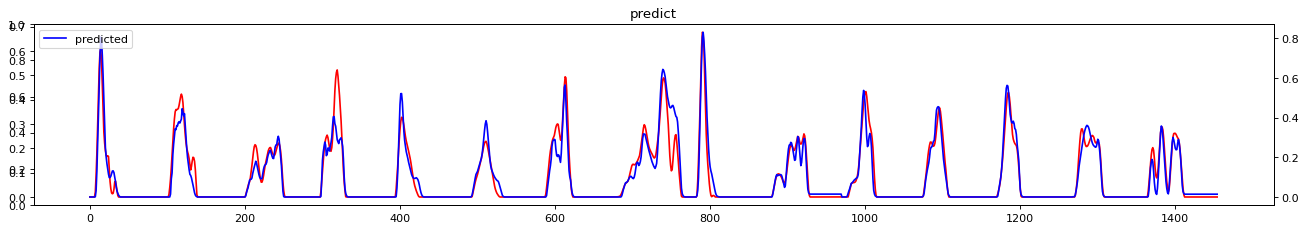

In [ ]:
# ------ All & SAVE ------
visual_1fig_list([result_predicted,y_test], name_list=['predicted', 'Y'], txtT='predict', s=(20, 3), twX=1, save=model_name_N+"-all.png")
# # ------ All по 5шт ------
# st, fn = st_fn_div_d(Ne=len(y_test), d=5, L1=Nsegm)
# for i in range(len(st)):
#     visual_1fig_list([result_predicted,y_test], name_list=['predicted', 'Y'], txtT='predict', s=(20, 3), twX=1, st=st[i], fn=fn[i])

##  PNG - save(15x)

<ipython-input-30-b1f727c8fed4>:48: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem([i1*t1, iQmax*t1, i2*t1], [Qmax_f]*3, ":b", 'none', ':r')
<ipython-input-30-b1f727c8fed4>:51: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes.stem([i1_f*t1, iQmax_f*t1, i2_f*t1], [Qmax_f]*3, ":r", 'none', ':r')


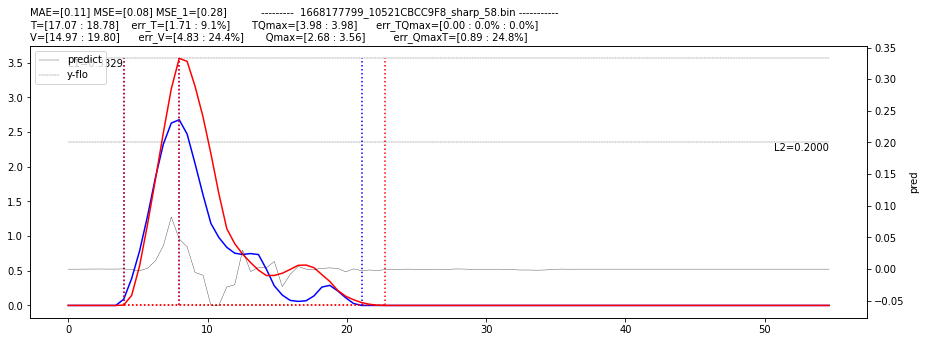

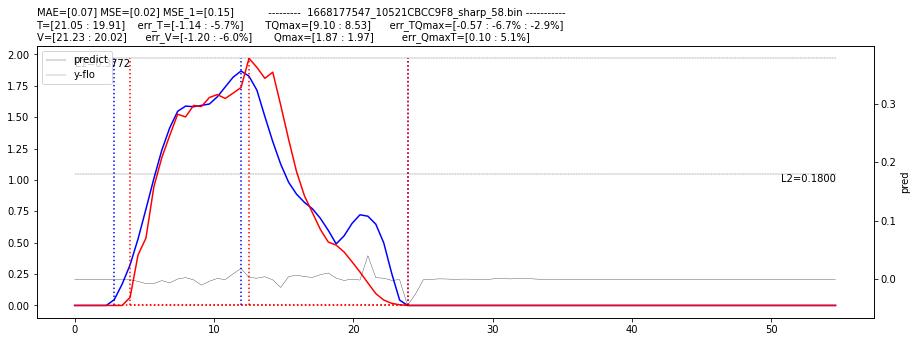

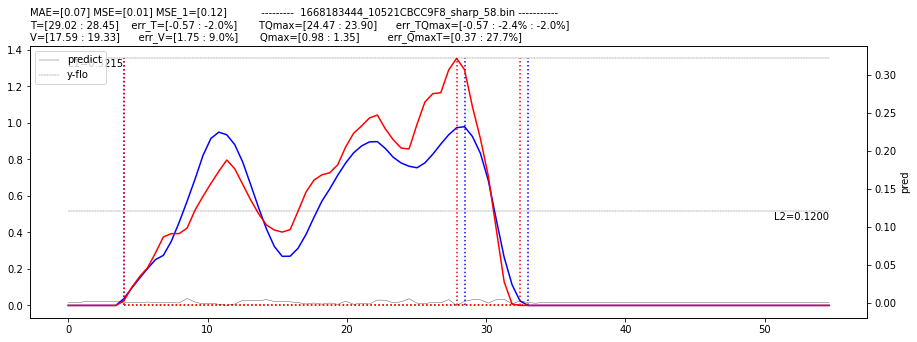

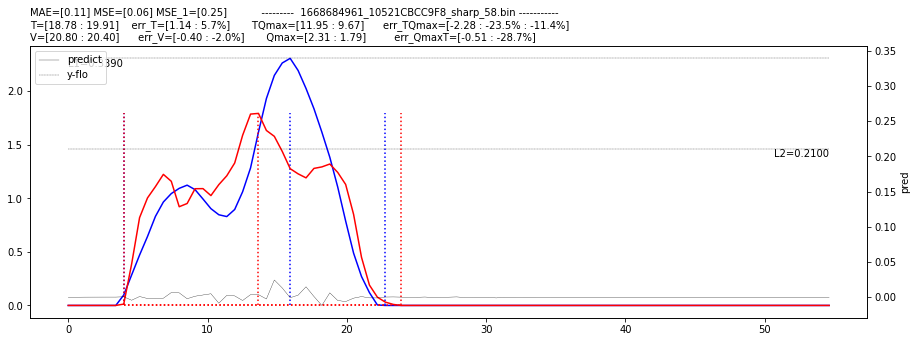

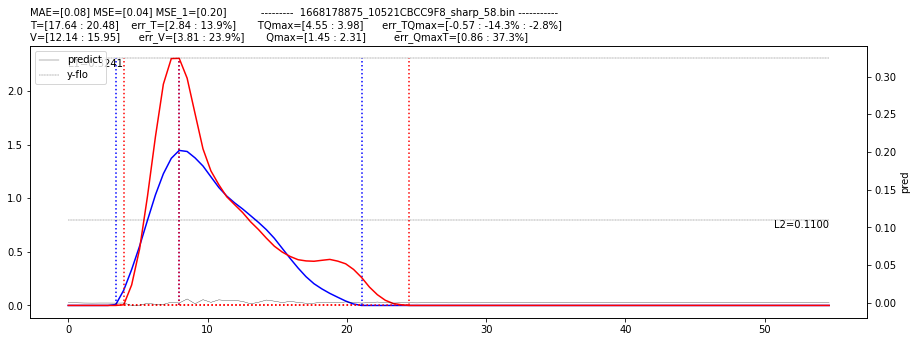

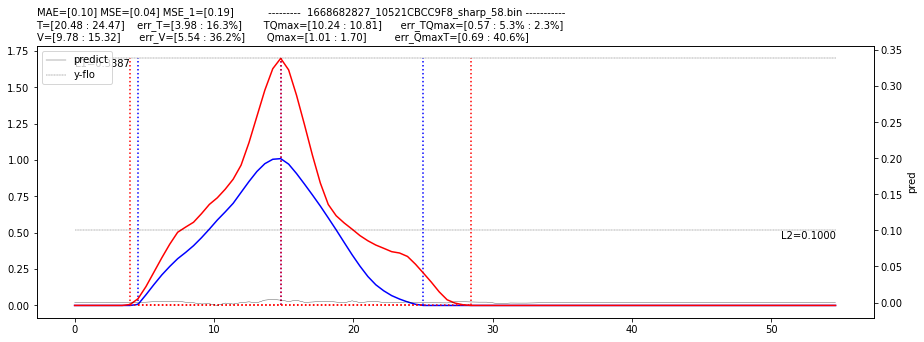

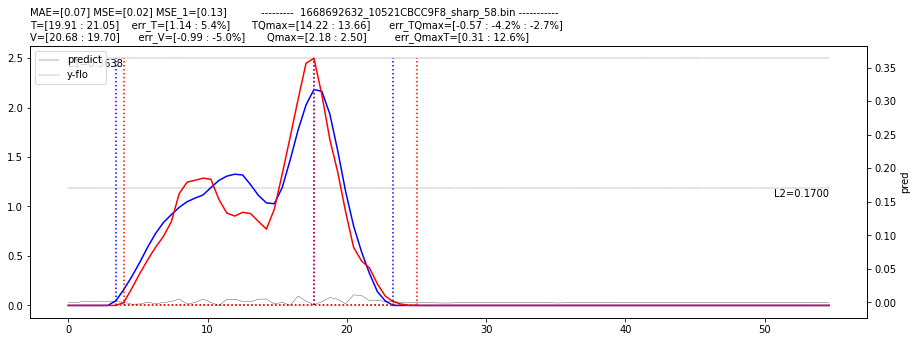

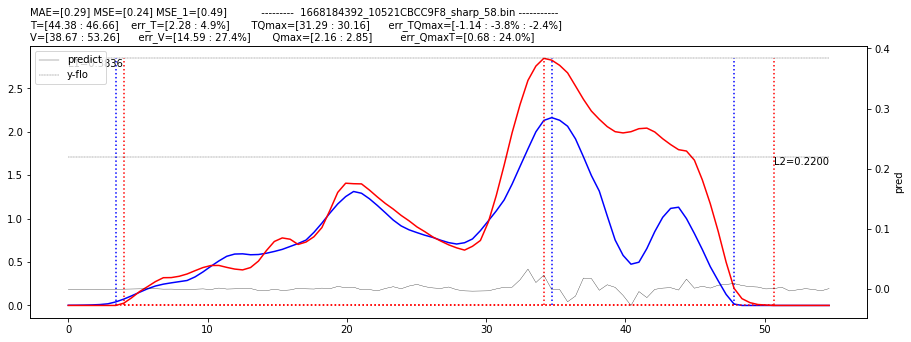

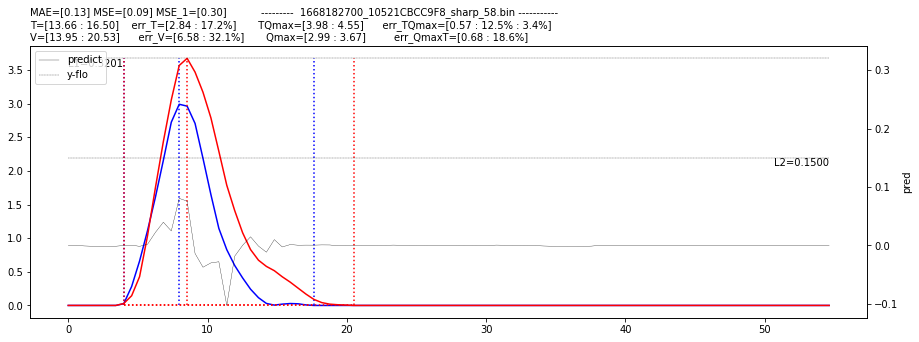

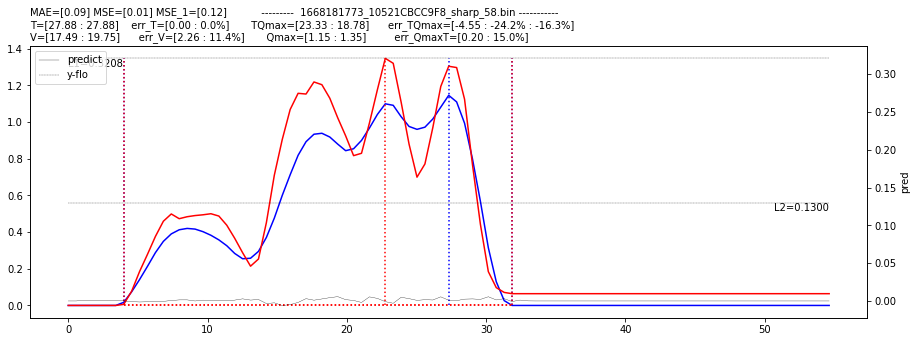

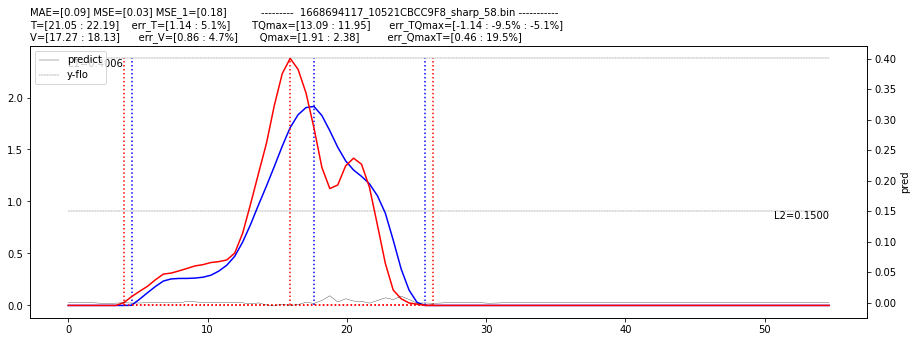

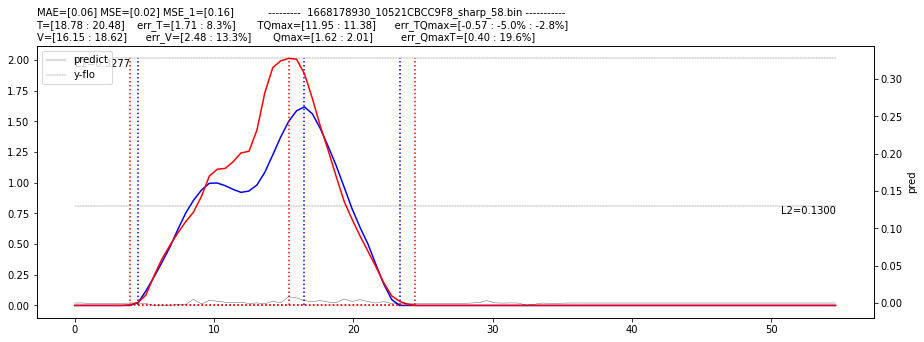

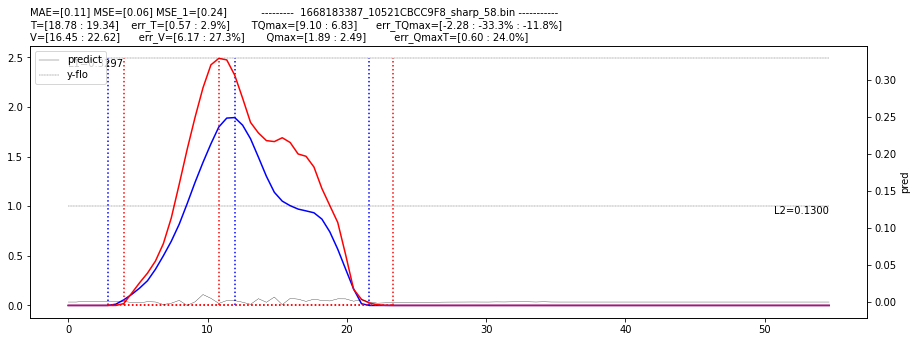

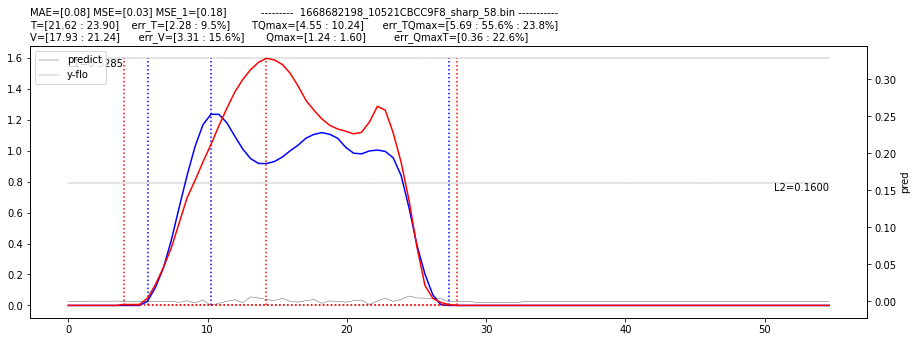

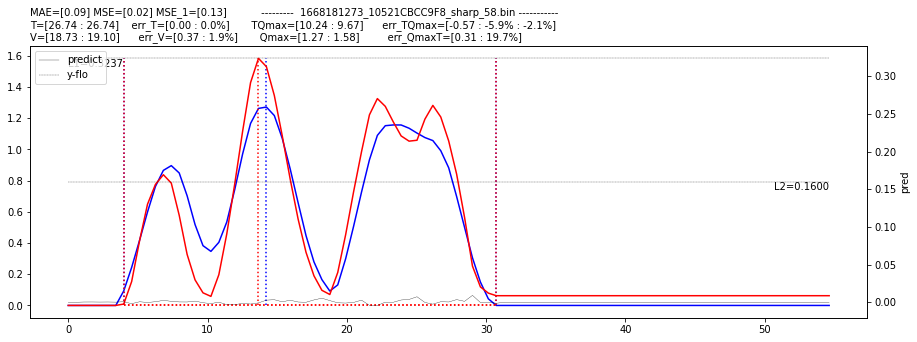

In [ ]:

result_save_name = ['N_exp', 'bin', 'L1', 'L2', 'T', 'T_f', 'err_T_a', 'err_T_r', 'TQmax', 'TQmax_f', 'err_TQmax_a', 'err_TQmax_r', 'err_TQmax_rn', 'Qmax', 'Qmax_f', 'err_Qmax_a', 'err_Qmax_r', 'V', 'V_f', 'err_V_a', 'err_V_r', 'MAE', 'MSE', 'MSE_1']
df_N_exp = pd.DataFrame(columns=result_save_name)
d1_save = dict(zip(result_save_name, [0]*len(result_save_name)))

N_file = len(bins2)
st, fn = st_fn_div_d(Ne=len(y_test), d=1, L1=Nsegm)
t1 = dl_segm / fs
t = [i*t1 for i in range(Nsegm)]

for i in range(N_file):    
    k=1
    xi =  [i*d_max['ef']*k for i in  result_predicted[st[i]:fn[i]] ]
    xi_f =  [i*d_max['ef']*k for i in  y_test[st[i]:fn[i]] ]
    xxi = x_param[0][st[i]:fn[i]]    

    L1 = x_param[2][st[i]]; L2=x_param[3][st[i]]
    # V_2 = (L2[st[i]] - L1[st[i]]) * d_max['xx']
    # print(f'L1={L1:0.4f}, L[0]={xxi[0]:0.4f}, L2={L2:0.4f}, L[-1]{xxi[-1]:0.4f}')
    
    i1, i2, iQmax, Qmax, V, T, TQmax = analiz_predict(xi, d_max['ef'])
    i1_f, i2_f, iQmax_f, Qmax_f, V_f, T_f, TQmax_f = analiz_predict(xi_f, d_max['ef'])

    err_T_a = (T_f-T);                  err_T_r = 100*err_T_a / T_f
    err_TQmax_a = (TQmax_f-TQmax);      err_TQmax_r = 100*err_TQmax_a / TQmax_f;    err_TQmax_rn = 100*err_TQmax_a / T_f;
    err_Qmax_a = (Qmax_f-Qmax);         err_Qmax_r = 100*err_Qmax_a / Qmax_f
    err_V_a = (V_f-V);                  err_V_r = 100*err_V_a / V_f
    MAE, MSE, MSE_1 =  MXE(xi, xi_f)

    d1_save['N_exp'] = N_exp; d1_save['bin'] = bins2[i];    d1_save['L1'] = L1;                   d1_save['L2'] = L2
    d1_save['T'] = T;         d1_save['T_f'] = T_f;         d1_save['err_T_a'] = err_T_a;         d1_save['err_T_r'] = err_T_r
    d1_save['TQmax'] = TQmax; d1_save['TQmax_f'] = TQmax_f; d1_save['err_TQmax_a'] = err_TQmax_a; d1_save['err_TQmax_r'] = err_TQmax_r;  d1_save['err_TQmax_rn'] = err_TQmax_rn
    d1_save['Qmax'] = Qmax;   d1_save['Qmax_f'] = Qmax_f;   d1_save['err_Qmax_a'] = err_Qmax_a;   d1_save['err_Qmax_r'] = err_Qmax_r
    d1_save['V'] = V;         d1_save['V_f'] = V_f;         d1_save['err_V_a'] = err_V_a;         d1_save['err_V_r'] = err_V_r
    d1_save['MAE'] = MAE;     d1_save['MSE'] = MSE;         d1_save['MSE_1'] = MSE_1
    df_N_exp = df_N_exp.append([d1_save])
    
    print('\n')
    title = f'''MAE=[{MAE:0.2f}] MSE=[{MSE:0.2f}] MSE_1=[{MSE_1:0.2f}]           ---------  {bins2[i]} -----------
T=[{T:0.2f} : {T_f:0.2f}]    err_T=[{err_T_a:0.2f} : {err_T_r:0.1f}%]       TQmax=[{TQmax:0.2f} : {TQmax_f:0.2f}]      err_TQmax=[{err_TQmax_a:0.2f} : {err_TQmax_r:0.1f}% : {err_TQmax_rn:0.1f}%] 
V=[{V:0.2f} : {V_f:0.2f}]      err_V=[{err_V_a:0.2f} : {err_V_r:0.1f}%]       Qmax=[{Qmax:0.2f} : {Qmax_f:0.2f}]         err_QmaxT=[{err_Qmax_a:0.2f} : {err_Qmax_r:0.1f}%]'''

    # figure(num=None, figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')  
    
    fig, axes = plt.subplots(1)
    fig.set_size_inches(15, 5 )    

    axes.plot(t, xi, c='b')
    axes.stem([i1*t1, iQmax*t1, i2*t1], [Qmax_f]*3, ":b", 'none', ':r')
    
    axes.plot(t, xi_f, c='r')    # linestyles : {'solid', 'dashed', 'dashdot', 'dotted'},
    axes.stem([i1_f*t1, iQmax_f*t1, i2_f*t1], [Qmax_f]*3, ":r", 'none', ':r')

    axes_left = axes.twinx()
    axes_left.plot(t, xxi, linewidth=0.3, c='k')
    axes_left.hlines(L1, 0, t[-1], colors='k', linestyles='dashed', linewidth=0.3, label=f'L1={L1:0.2f}')
    axes_left.text(0, L1, f'L1={L1:0.4f}', ha='left', va='top')
    axes_left.hlines(L2, 0, t[-1], colors='k', linestyles='dashed', linewidth=0.3, label=f'L2={L2:0.2f}')
    axes_left.text(t[-1], L2, f'L2={L2:0.4f}', ha='right', va='top')
    axes_left.legend()   
    plt.title(title, loc='left',  fontsize=10, fontweight=4 ) #fontdict
    plt.ylabel('pred'); plt.xlabel('t, ms')
    plt.legend(['predict', 'y-flo'], loc='upper left')      
    plt.savefig(gpath_N+d1_save['bin']+'_'+str(N_exp)+'.png' )    
    plt.show()



## CSV - save(15x)

In [ ]:
# ------ создать пустой df_result --------
# df_result = pd.DataFrame(columns=result_save_name )
# df_result.to_csv(gpath+'result-all.csv', index=False)
# # ------ создать пустой df_MxS --------
# df_MxS = pd.DataFrame(columns=['N_exp', 'MAE', 'MSE', 'MSE_1'] + list(df_exp_col))
# df_MxS.to_csv(gpath+'MAE_MSE.csv', index=False)


# ------ Загрузить df_result, дописать df_N_exp и сохранить --------
df_result = pd.read_csv(gpath+'result-all.csv')
df_result = df_result.append(df_N_exp, ignore_index = True )
df_result.to_csv(gpath+'result-all.csv', index=False)


In [ ]:
# ------ Загрузить df_result, дописать df_N_exp и сохранить --------
df_result = pd.read_csv(gpath+'result-all.csv')
df_result = df_result.append(df_N_exp, ignore_index = True )
df_result.to_csv(gpath+'result-all.csv', index=False)
# # ------ Загрузить df_MxS, дописать и сохранить --------
df_MxS = pd.read_csv(gpath+'MAE_MSE.csv')
df_MxS.loc[len(df_MxS)] = [N_exp, sum(df_N_exp['MAE'])/N_file, sum(df_N_exp['MSE'])/N_file, sum(df_N_exp['MSE_1'])/N_file] + list(exp_i)
df_MxS.to_csv(gpath+'MAE_MSE.csv', index=False)


## Пирсон

In [ ]:
import numpy as np

a = [1, 2, 3, 4, 5]
b = [10, 9, 2.5, 6, 4]

from scipy import stats
Pearson = stats.pearsonr(a, b)[0]
Pearson = np.corrcoef(a, b)[0,1]

(-0.7426106572325059, 0.15055580885344538)

In [ ]:
Pearson = np.corrcoef(a, b)[0,1]


[[ 1.         -0.74261066]
 [-0.74261066  1.        ]] -0.7426106572325056


-0.7426106572325056

In [ ]:
param_names

i_L1 = [i for i,x in enumerate(param_names) if 'L1'==x]
i_L2 = [i for i,x in enumerate(param_names) if 'L1'==x]
if len(i_L1)==1: print(5)

5


In [ ]:
print(param_names)
print(df.segment[0].ef[0],df.segment[0].L2[0]*d_max['xx'])
np.mean(df.segment[0][-10:])

['xx', 'f_nf_1', 'L1', 'L2', 'Np', 'Nh', 'd', 'ds', 'f_03', 'f_1', 'd_f_03', 'd_f_1', 'd_f_1_28', 'd_f_1_5', 'd_f_5_15', 'd_f_15_20', 'd_f_20_28']
0.0 7564.74


ind          1.885000e+02
xx           3.043036e-01
ev           4.110329e-01
ef           0.000000e+00
f_03         5.116541e-01
f_1          4.540478e-01
f_1_28       3.585278e-14
f_1_5        6.379919e-14
f_5_15       5.278879e-19
f_15_20     -6.493128e-20
f_20_28      6.434134e-16
f_nf_1      -2.041884e-11
d            8.808116e-12
ds           8.590556e-12
d_f_03       2.087033e-07
d_f_1        1.018687e-11
d_f_1_28     3.855805e-13
d_f_1_5      4.269459e-13
d_f_5_15     3.786121e-16
d_f_15_20    6.325657e-17
d_f_20_28    7.381314e-13
L1           2.908994e-01
L2           3.077099e-01
mx           0.000000e+00
mn_mx        0.000000e+00
Np           1.300000e-01
Nh           2.000000e-02
dtype: float64